In [5]:
import numpy as np
import pandas as pd
import ta
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch 15-minute data for the last month for BTCGBP
ticker = 'BTC-USD'
ticker_data = yf.Ticker(ticker)

end_date = pd.Timestamp.now()
start_date = end_date - pd.Timedelta(days=30)

data_frames = []
while start_date < end_date:
    # Calculate the end of the 7-day period
    seven_days_later = start_date + pd.Timedelta(days=7)
    if seven_days_later > end_date:
        seven_days_later = end_date
    
    # Fetch data for the 7-day period
    df = ticker_data.history(interval='1h', start=start_date, end=seven_days_later)
    data_frames.append(df)
    
    # Update start_date to the next day after the 7-day period
    start_date = seven_days_later + pd.Timedelta(minutes=1)

# Concatenate all data frames into one
data = pd.concat(data_frames)

# Convert column names to lowercase
data.columns = [col.lower() for col in data.columns]

data

open          high           low  \
Datetime                                                              
2024-05-25 22:00:00+00:00  69135.101562  69135.101562  69052.375000   
2024-05-25 23:00:00+00:00  69107.429688  69333.125000  69107.429688   
2024-05-26 00:00:00+00:00  69279.484375  69296.187500  69145.109375   
2024-05-26 01:00:00+00:00  69155.312500  69241.375000  69151.437500   
2024-05-26 02:00:00+00:00  69162.046875  69167.898438  68867.445312   
...                                 ...           ...           ...   
2024-06-24 18:00:00+00:00  60206.003906  60395.746094  59807.558594   
2024-06-24 19:00:00+00:00  60370.363281  60418.937500  59198.535156   
2024-06-24 20:00:00+00:00  59554.414062  59554.414062  58693.835938   
2024-06-24 21:00:00+00:00  59492.640625  60009.558594  59393.445312   
2024-06-24 22:00:00+00:00  60044.238281  60050.527344  59971.164062   

                                  close      volume  dividends  stock splits  
Datetime                                                                      
2024-05-25 22:00:00+00:00  69115.562500           0        0.0           0.0  
2024-05-25 23:00:00+00:00  69273.148438           0        0.0           0.0  
2024-05-26 00:00:00+00:00  69158.000000           0        0.0           0.0  
2024-05-26 01:00:00+00:00  69167.710938           0        0.0           0.0  
2024-05-26 02:00:00+00:00  68913.695312   113649664        0.0           0.0  
...                                 ...         ...        ...           ...  
2024-06-24 18:00:00+00:00  60335.726562  1845919744        0.0           0.0  
2024-06-24 19:00:00+00:00  59198.535156  1432023040        0.0           0.0  
2024-06-24 20:00:00+00:00  59497.394531  2965626880        0.0           0.0  
2024-06-24 21:00:00+00:00  60009.558594  1020760064        0.0           0.0  
2024-06-24 22:00:00+00:00  59986.523438    75857920        0.0           0.0  

[721 rows x 7 columns]

In [6]:
base_kraken_path = '../data/kraken'

def get_data_from_kraken_csv(symbol: str, interval: str, window: int = None, skip: int = None, buffer: int = None, start_date: pd.Timestamp = None, end_date: pd.Timestamp = None):
    column_names = ['date_unix', 'open', 'high', 'low', 'close', 'volume', 'trades']
    df = pd.read_csv(f'{base_kraken_path}/{symbol}_{interval}.csv', names=column_names)
    
    df['date'] = pd.to_datetime(df['date_unix'], unit='s')
    del df['date_unix']
    df = df.set_index('date')

    if start_date is not None and end_date is not None:
        df = df[start_date:end_date]
    else:
        start_index = max(len(df) - window - buffer - window * skip, 0)
        end_index = max(len(df) - window * skip, 0)
        df = df.iloc[start_index:end_index]
    return df

#data = get_data_from_kraken_csv('XBTUSDT', '60', 720, 4, 168)
data = get_data_from_kraken_csv('XBTUSDT', '60', start_date=pd.Timestamp('2021-09-01'), end_date=pd.Timestamp('2021-10-01'))
data

open     high      low    close    volume  trades
date                                                                     
2021-09-01 00:00:00  47103.8  47289.0  46748.9  46763.4  6.454117     136
2021-09-01 01:00:00  46734.3  46861.4  46560.6  46861.4  7.247905     145
2021-09-01 02:00:00  46820.3  47084.7  46761.6  46874.0  0.933202      67
2021-09-01 03:00:00  46868.9  47005.4  46740.3  47005.4  1.168069      91
2021-09-01 04:00:00  47022.6  47240.2  46981.9  47129.4  4.546941     119
...                      ...      ...      ...      ...       ...     ...
2021-09-30 20:00:00  43558.6  43735.6  43156.3  43431.8  7.368952     168
2021-09-30 21:00:00  43408.6  43787.5  43390.9  43787.5  3.137095     163
2021-09-30 22:00:00  43785.4  43898.4  43652.8  43742.9  4.778271     103
2021-09-30 23:00:00  43753.7  43890.0  43637.9  43824.0  2.340164      45
2021-10-01 00:00:00  43804.5  44049.6  43696.6  43746.7  4.633744     108

[721 rows x 6 columns]

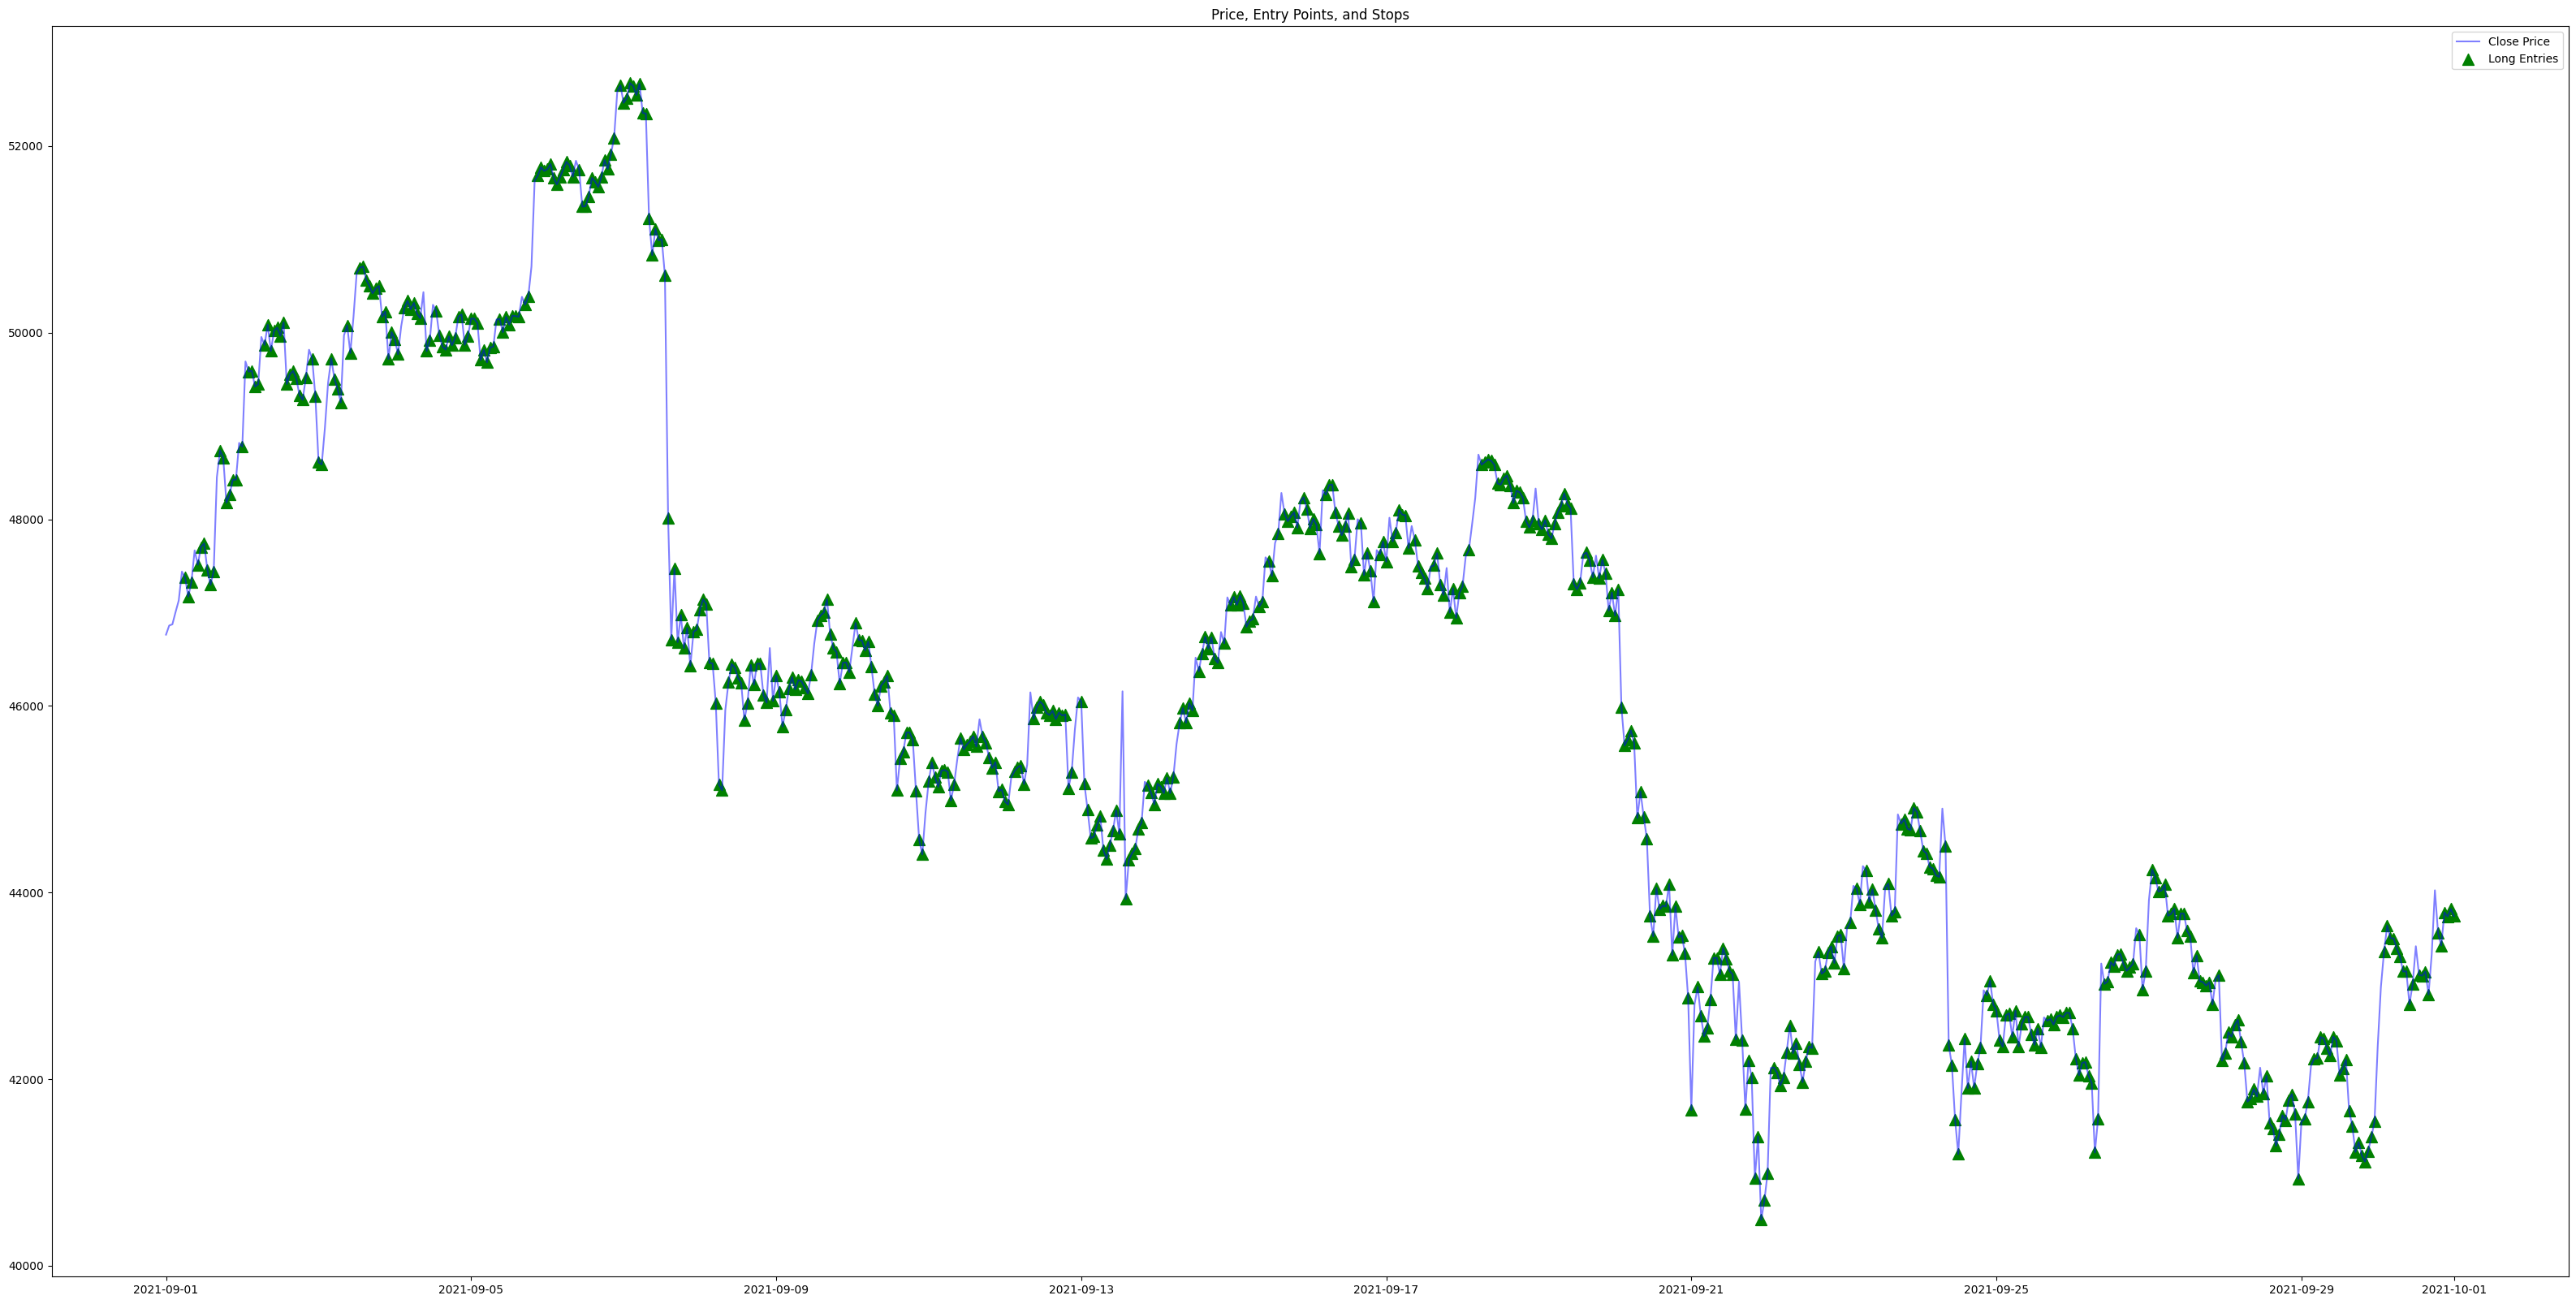

In [7]:
# Define the strategy parameters
length = 5
numATRs = 0.75

# Calculate the ATR based on the defined length and multiplier
data['atr'] = ta.volatility.average_true_range(data['high'], data['low'], data['close'], length) * numATRs

# Define upper and lower bands
data['upper_band'] = data['close'].shift(1) + data['atr'].shift(1)
data['lower_band'] = data['close'].shift(1) - data['atr'].shift(1)

data['long_entry'] = (data['close'] < data['upper_band'])
data['short_entry'] = (data['close'] > data['lower_band'])

# Plotting the price, bands, entry points, RSI, and MACD for visualization
fig, (ax1) = plt.subplots(1, 1, figsize=(40, 20))

# Plot price, bands, and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
#ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price, Entry Points, and Stops')
ax1.legend()

plt.show()


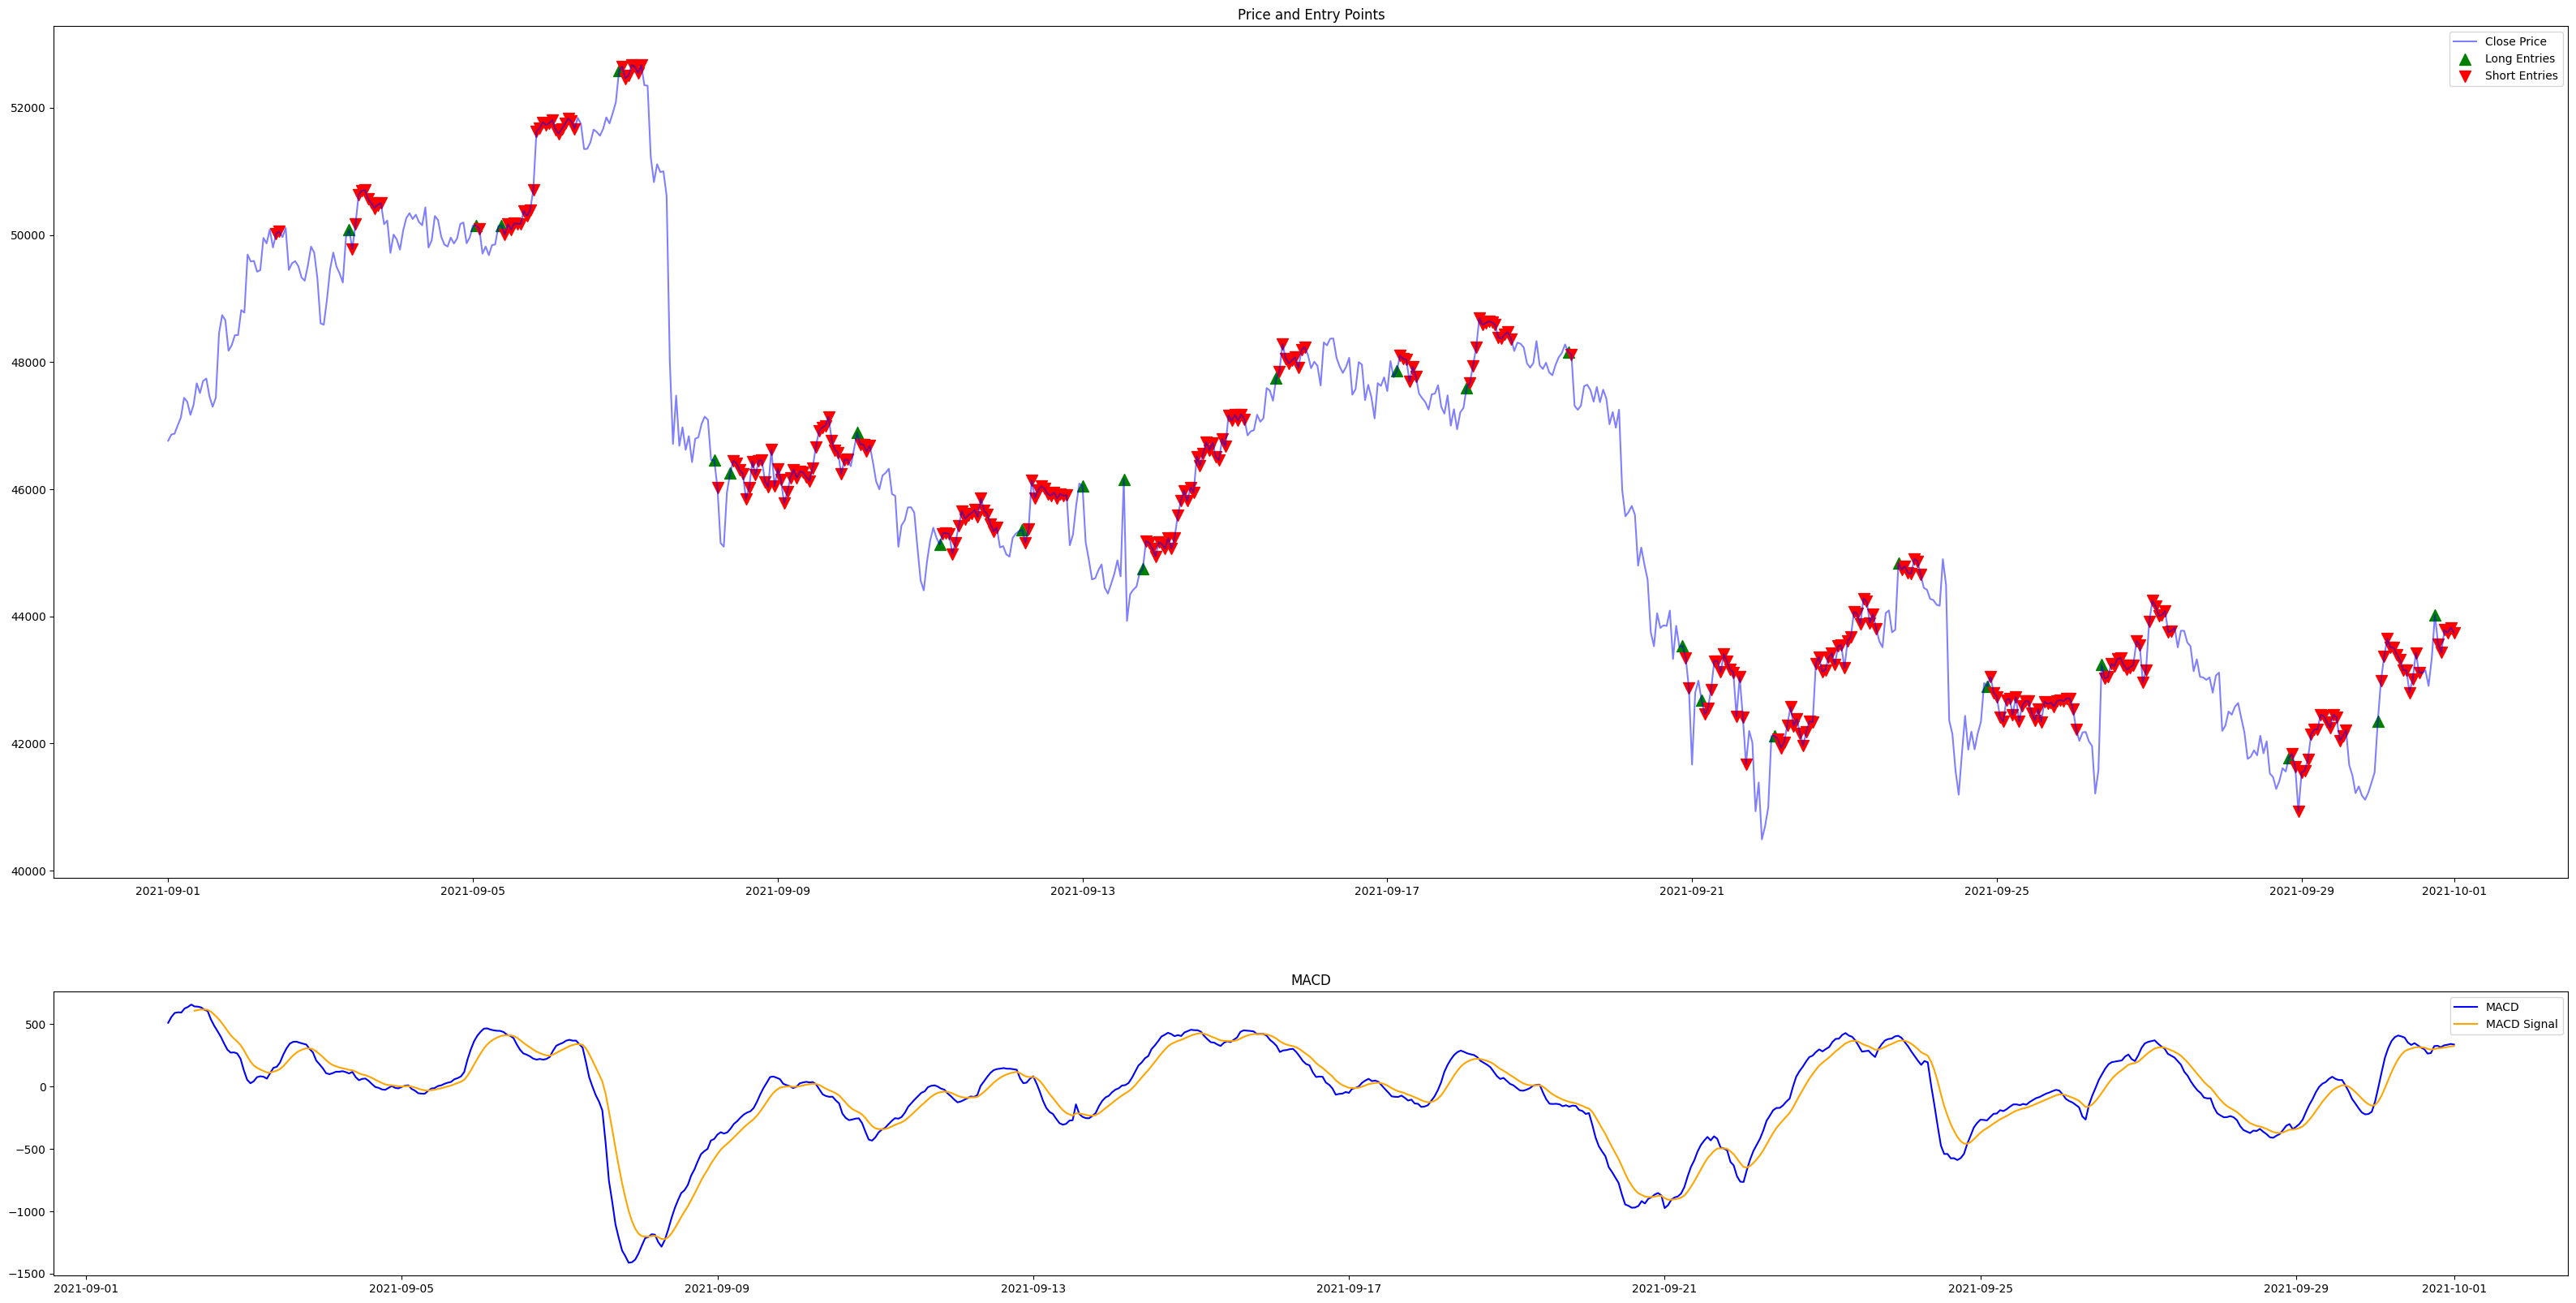

In [8]:
# Calculate MACD and its signal line
data['macd'] = ta.trend.macd(data['close'], window_slow=26, window_fast=12)
data['macd_signal'] = ta.trend.macd_signal(data['close'], window_slow=26, window_fast=12, window_sign=9)

data['macd_last'] = data['macd'].shift(1)
data['macd_signal_last'] = data['macd_signal'].shift(1)

data['long_entry'] = (data['macd'] > data['macd_signal']) & (data['macd_last'] < data['macd_signal_last'])
data['short_entry'] = (data['macd_signal'] < data['macd']) & (data['macd_last'] > data['macd_signal_last'])

# Plotting the price, MACD, RSI, and CCI for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price and Entry Points')
ax1.legend()

# Plot MACD
ax2.plot(data['macd'], label='MACD', color='blue')
ax2.plot(data['macd_signal'], label='MACD Signal', color='orange')
ax2.set_title('MACD')
ax2.legend()

plt.show()


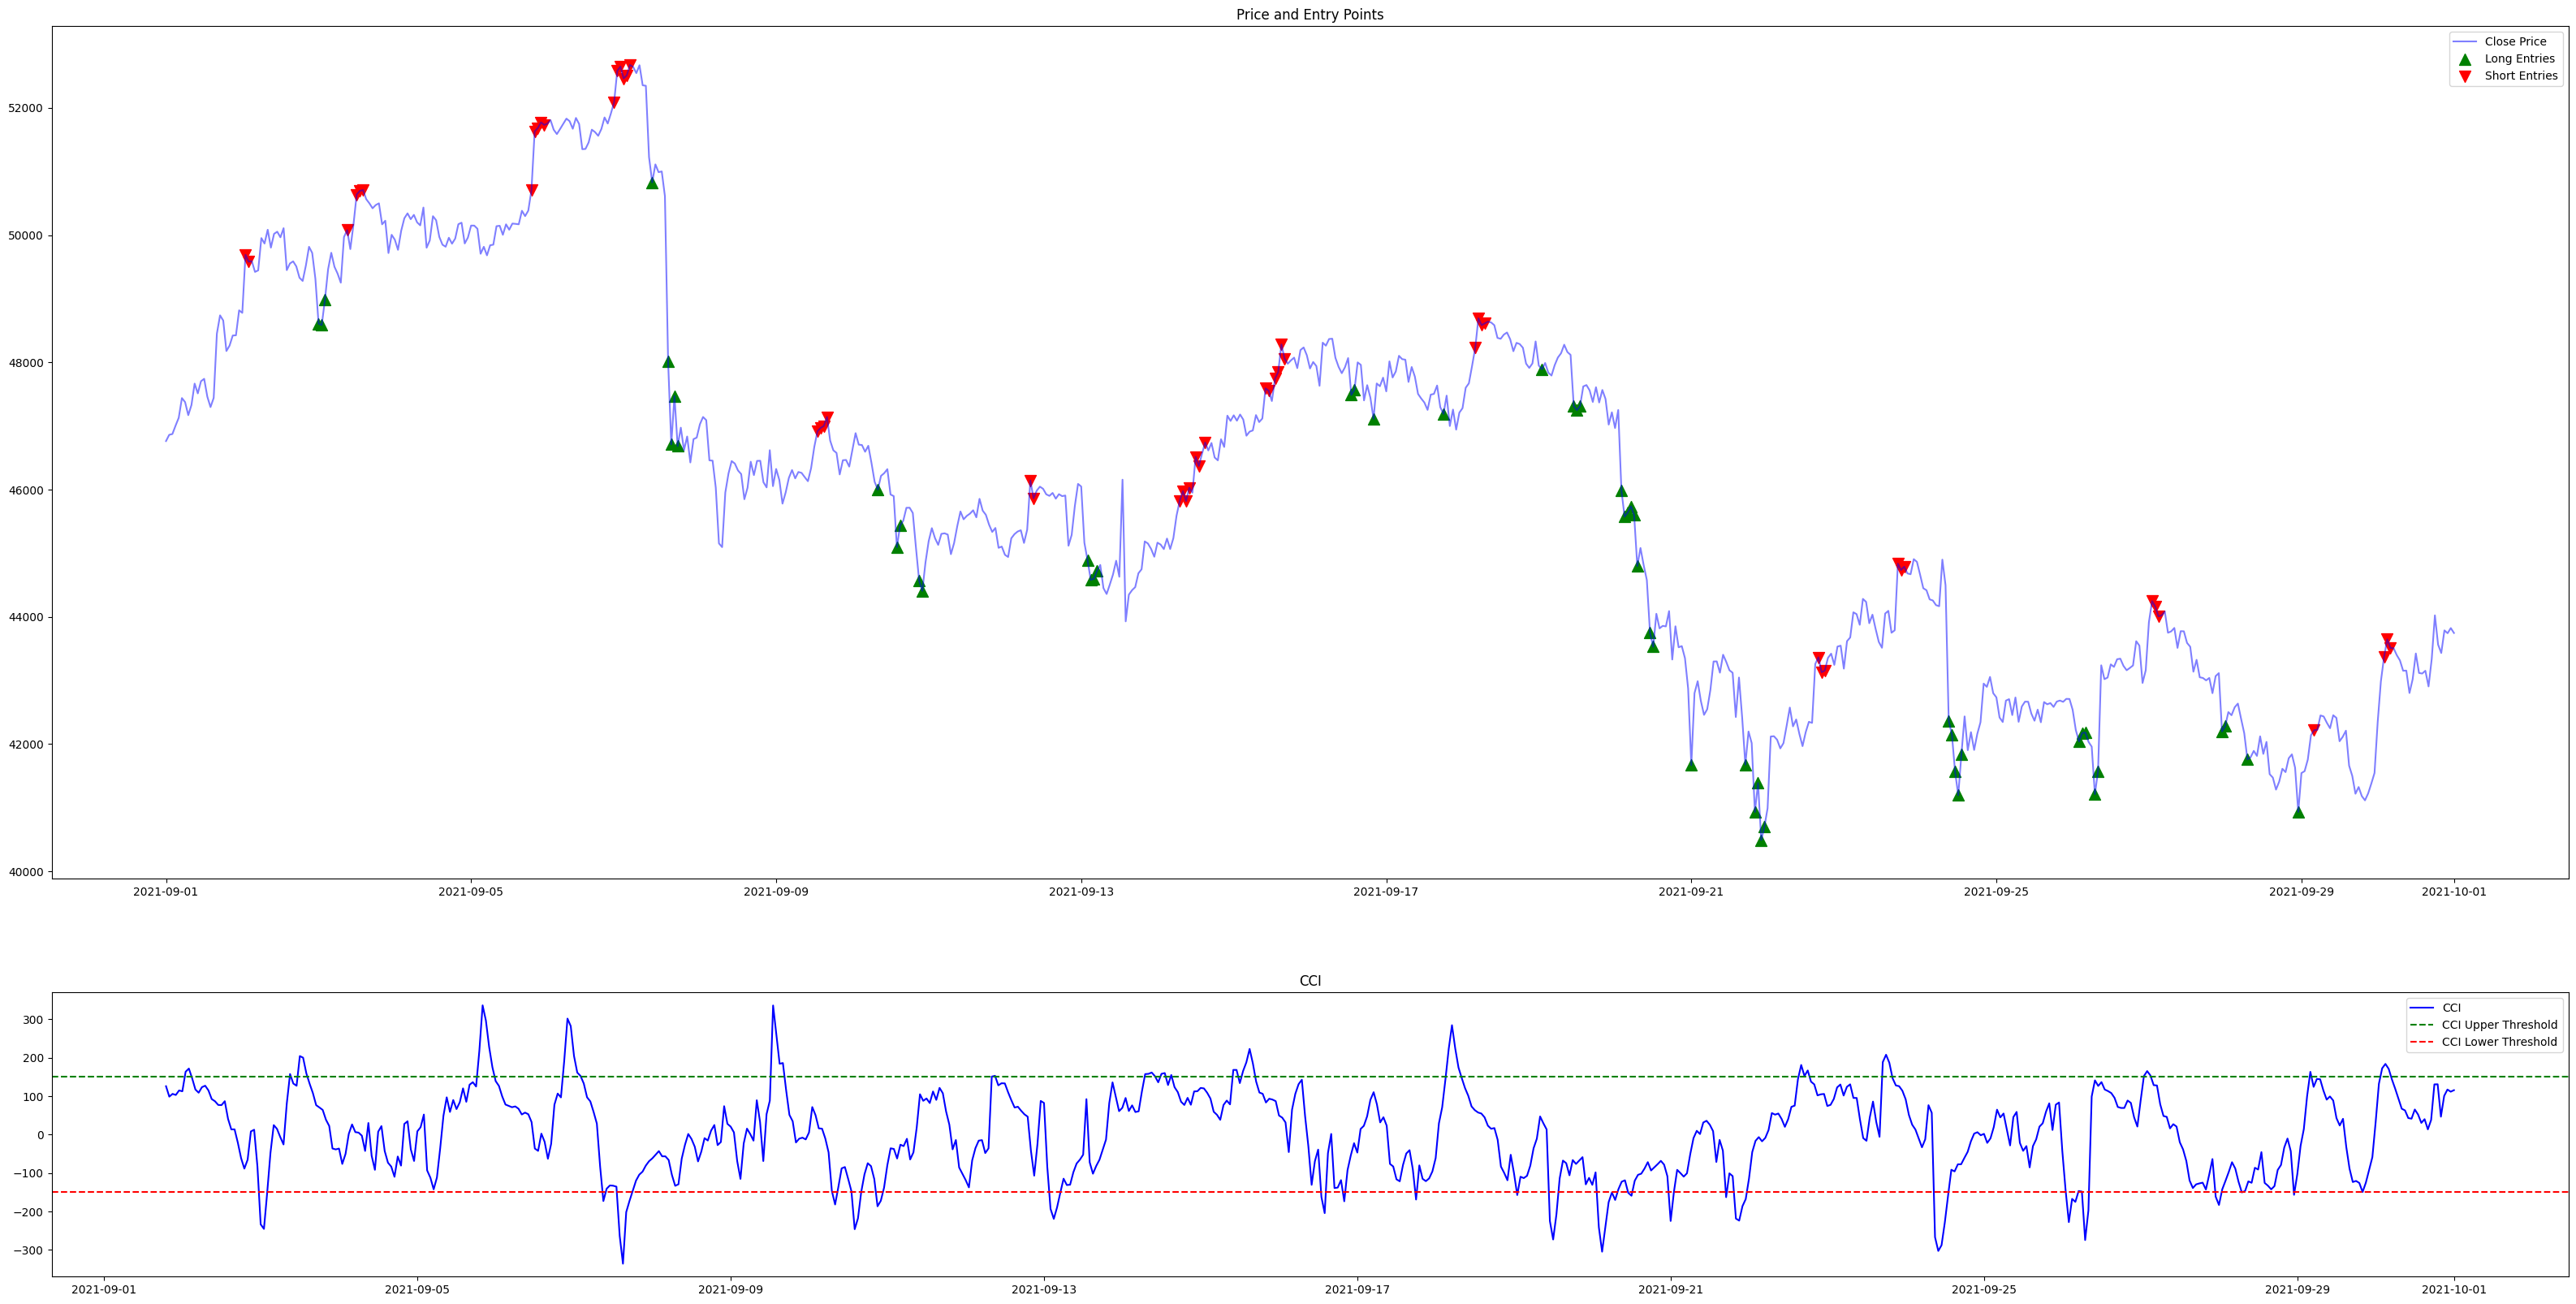

In [9]:
# Calculate CCI
data['cci'] = ta.trend.cci(data['high'], data['low'], data['close'])

# Define CCI trend direction with a reasonable margin
cci_upper_threshold = 150
cci_lower_threshold = -150
data['cci_oversold'] = data['cci'] < cci_lower_threshold
data['cci_overbought'] = data['cci'] > cci_upper_threshold

data['long_entry'] = data['cci_oversold']
data['short_entry'] = data['cci_overbought']

# Plotting the price, CCI, RSI, and CCI for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price and Entry Points')
ax1.legend()

# Plot CCI
ax2.plot(data['cci'], label='CCI', color='blue')
ax2.axhline(y=cci_upper_threshold, color='green', linestyle='--', label='CCI Upper Threshold')
ax2.axhline(y=cci_lower_threshold, color='red', linestyle='--', label='CCI Lower Threshold')
ax2.set_title('CCI')
ax2.legend()

plt.show()

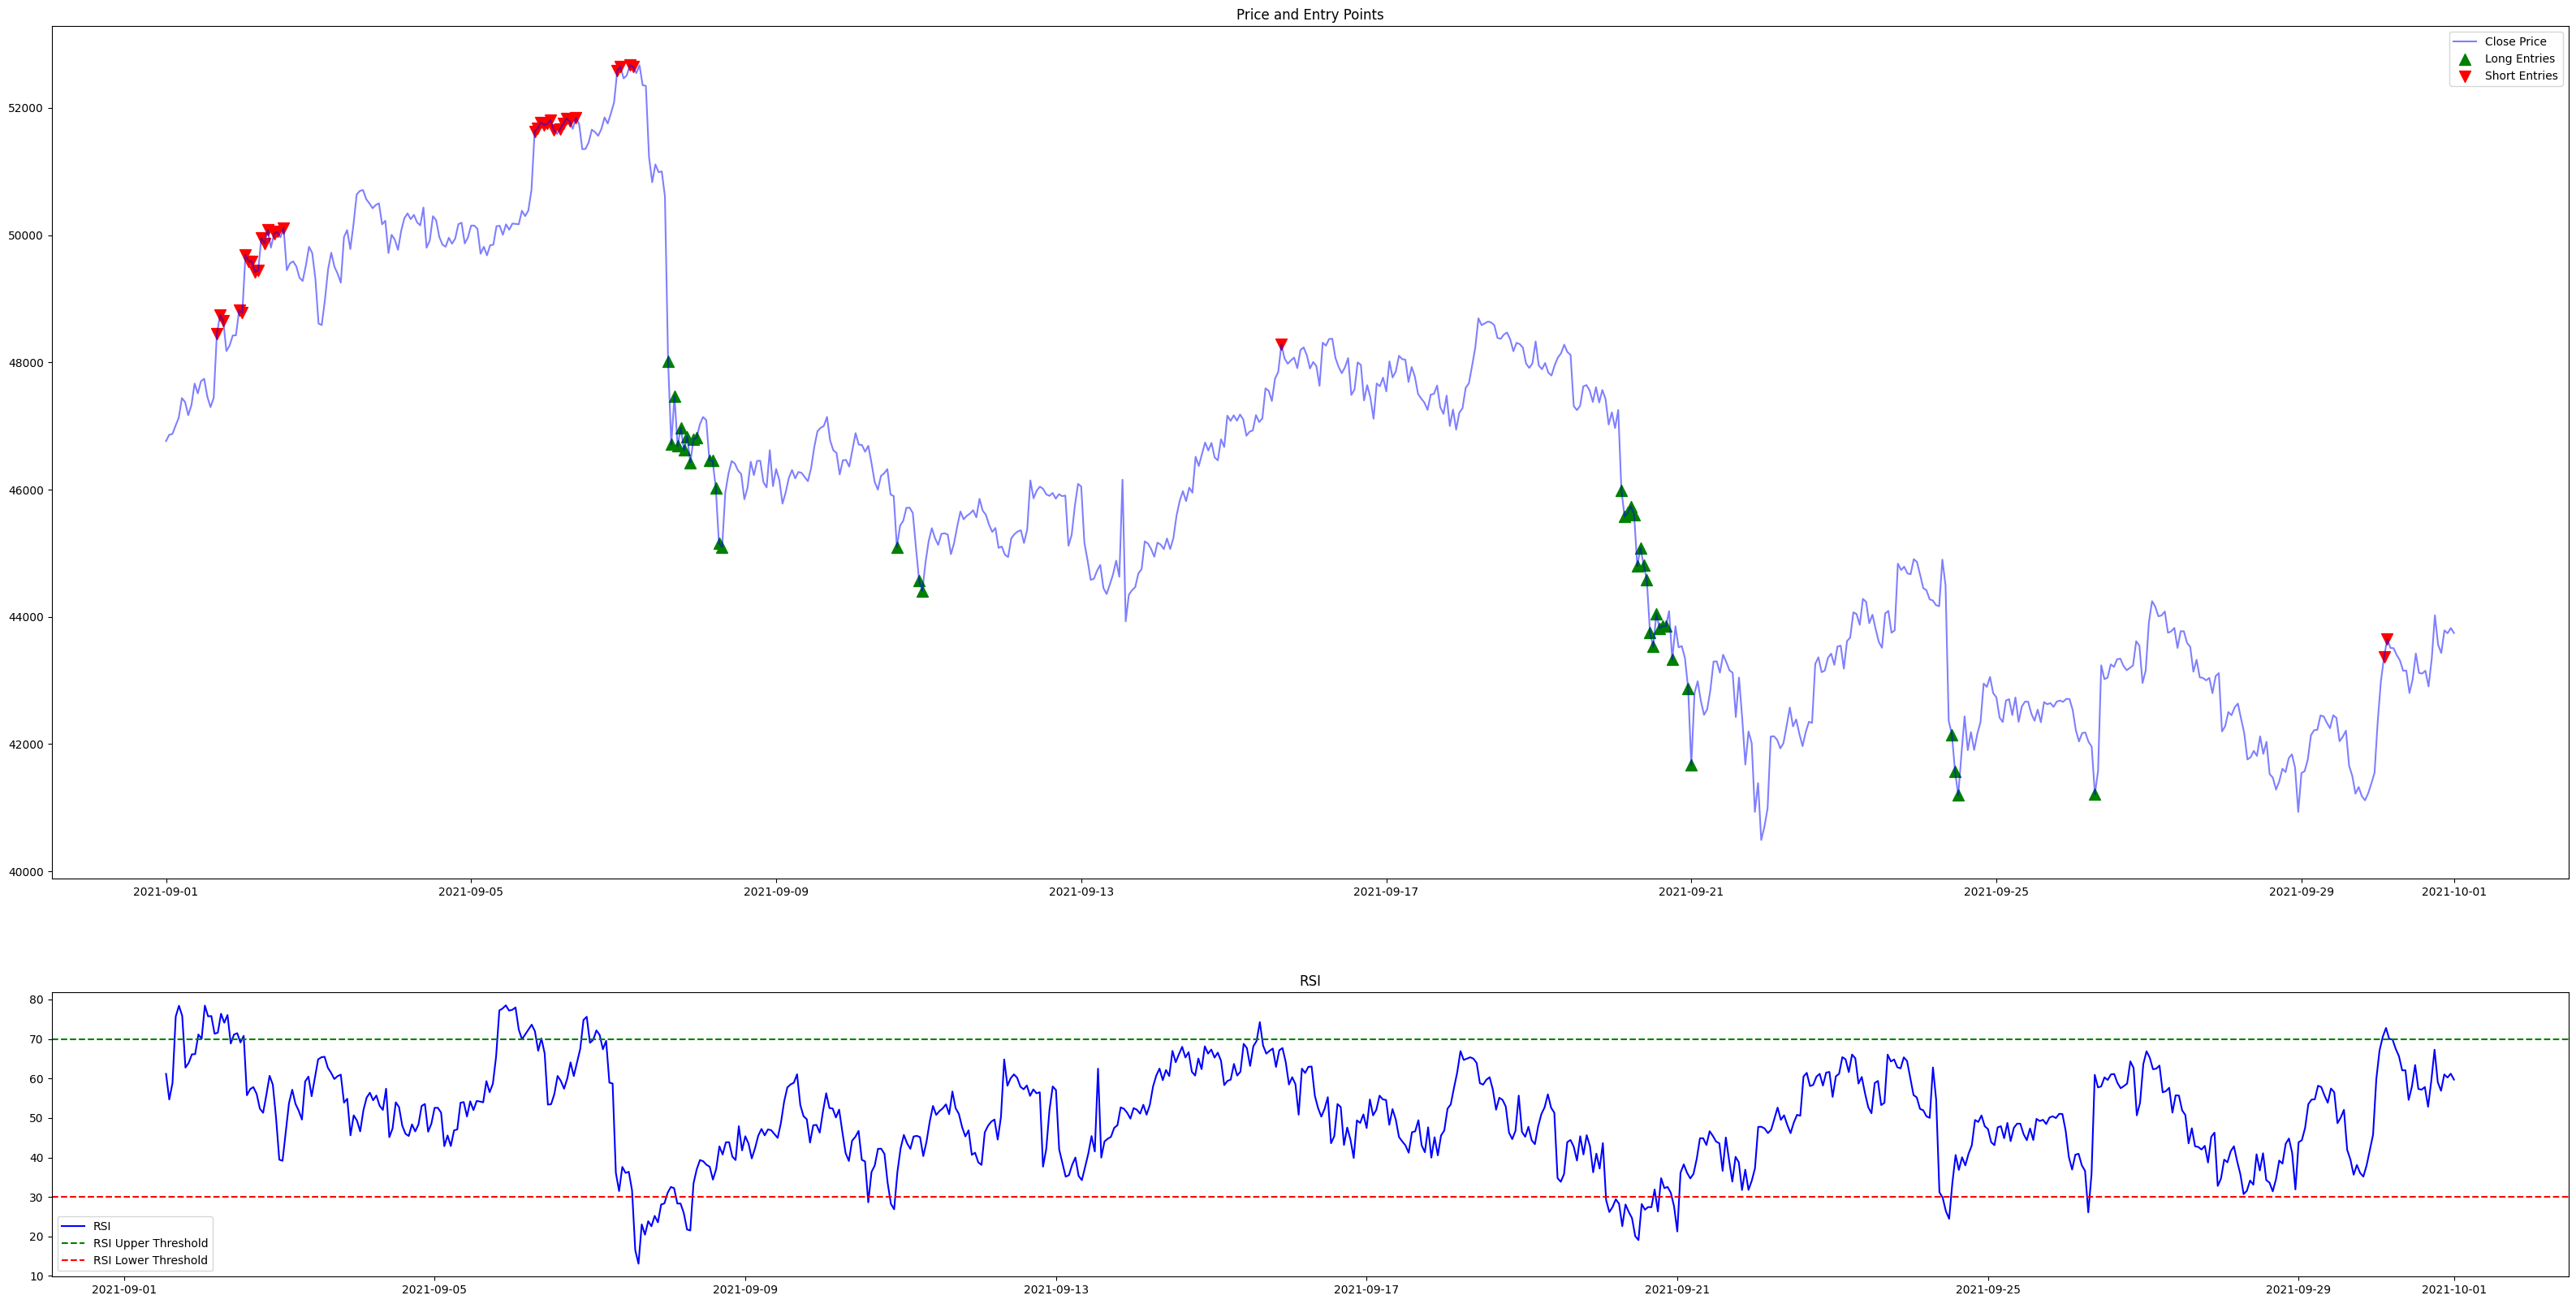

In [10]:
# Calculate RSI
data['rsi'] = ta.momentum.rsi(data['close'])

# Define RSI trend direction with a reasonable margin
rsi_upper_threshold = 70
rsi_lower_threshold = 30
data['rsi_oversold'] = data['rsi'] < rsi_lower_threshold
data['rsi_overbought'] = data['rsi'] > rsi_upper_threshold

data['long_entry'] = data['rsi_oversold']
data['short_entry'] = data['rsi_overbought']

# Plotting the price and RSI for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price and Entry Points')
ax1.legend()

# Plot RSI
ax2.plot(data['rsi'], label='RSI', color='blue')
ax2.axhline(y=rsi_upper_threshold, color='green', linestyle='--', label='RSI Upper Threshold')
ax2.axhline(y=rsi_lower_threshold, color='red', linestyle='--', label='RSI Lower Threshold')
ax2.set_title('RSI')
ax2.legend()

plt.show()

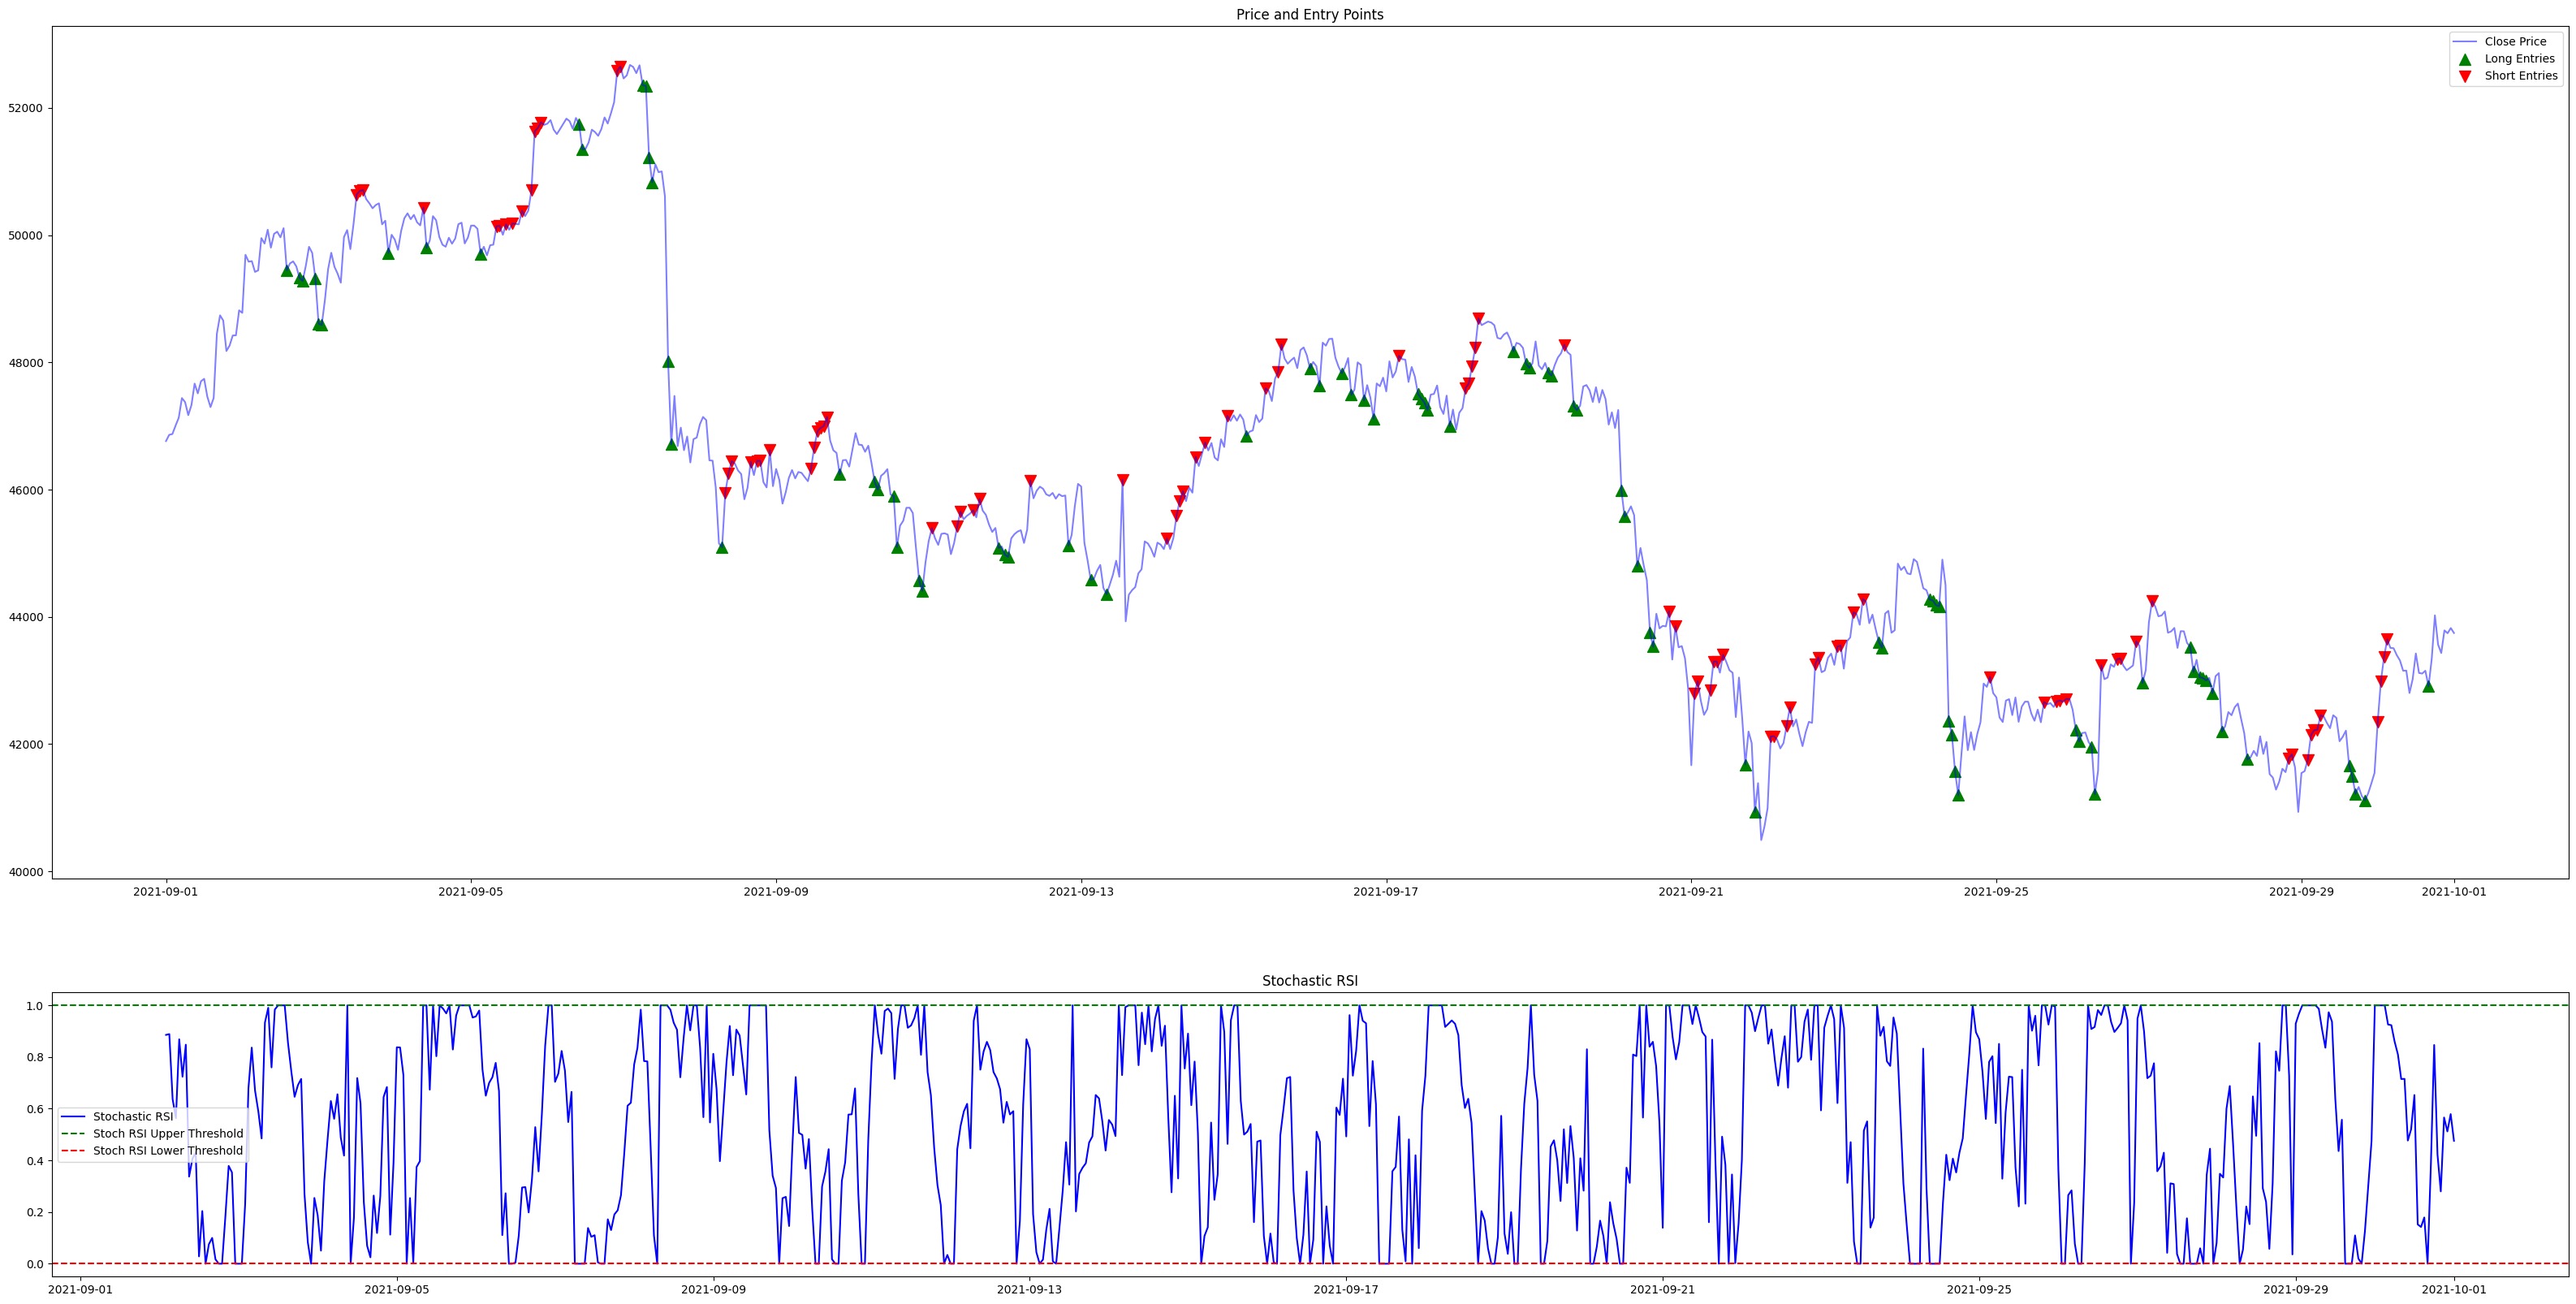

In [11]:
# Calculate Stochastic RSI
data['stoch_rsi'] = ta.momentum.stochrsi(data['close'])

# Define Stochastic RSI trend direction with a reasonable margin
stoch_rsi_upper_threshold = .999999
stoch_rsi_lower_threshold = 0.000001
data['stoch_rsi_oversold'] = data['stoch_rsi'] < stoch_rsi_lower_threshold
data['stoch_rsi_overbought'] = data['stoch_rsi'] > stoch_rsi_upper_threshold

data['long_entry'] = data['stoch_rsi_oversold']
data['short_entry'] = data['stoch_rsi_overbought']

# Plotting the price and Stochastic RSI for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price and Entry Points')
ax1.legend()

# Plot Stochastic RSI
ax2.plot(data['stoch_rsi'], label='Stochastic RSI', color='blue')
ax2.axhline(y=stoch_rsi_upper_threshold, color='green', linestyle='--', label='Stoch RSI Upper Threshold')
ax2.axhline(y=stoch_rsi_lower_threshold, color='red', linestyle='--', label='Stoch RSI Lower Threshold')
ax2.set_title('Stochastic RSI')
ax2.legend()

plt.show()

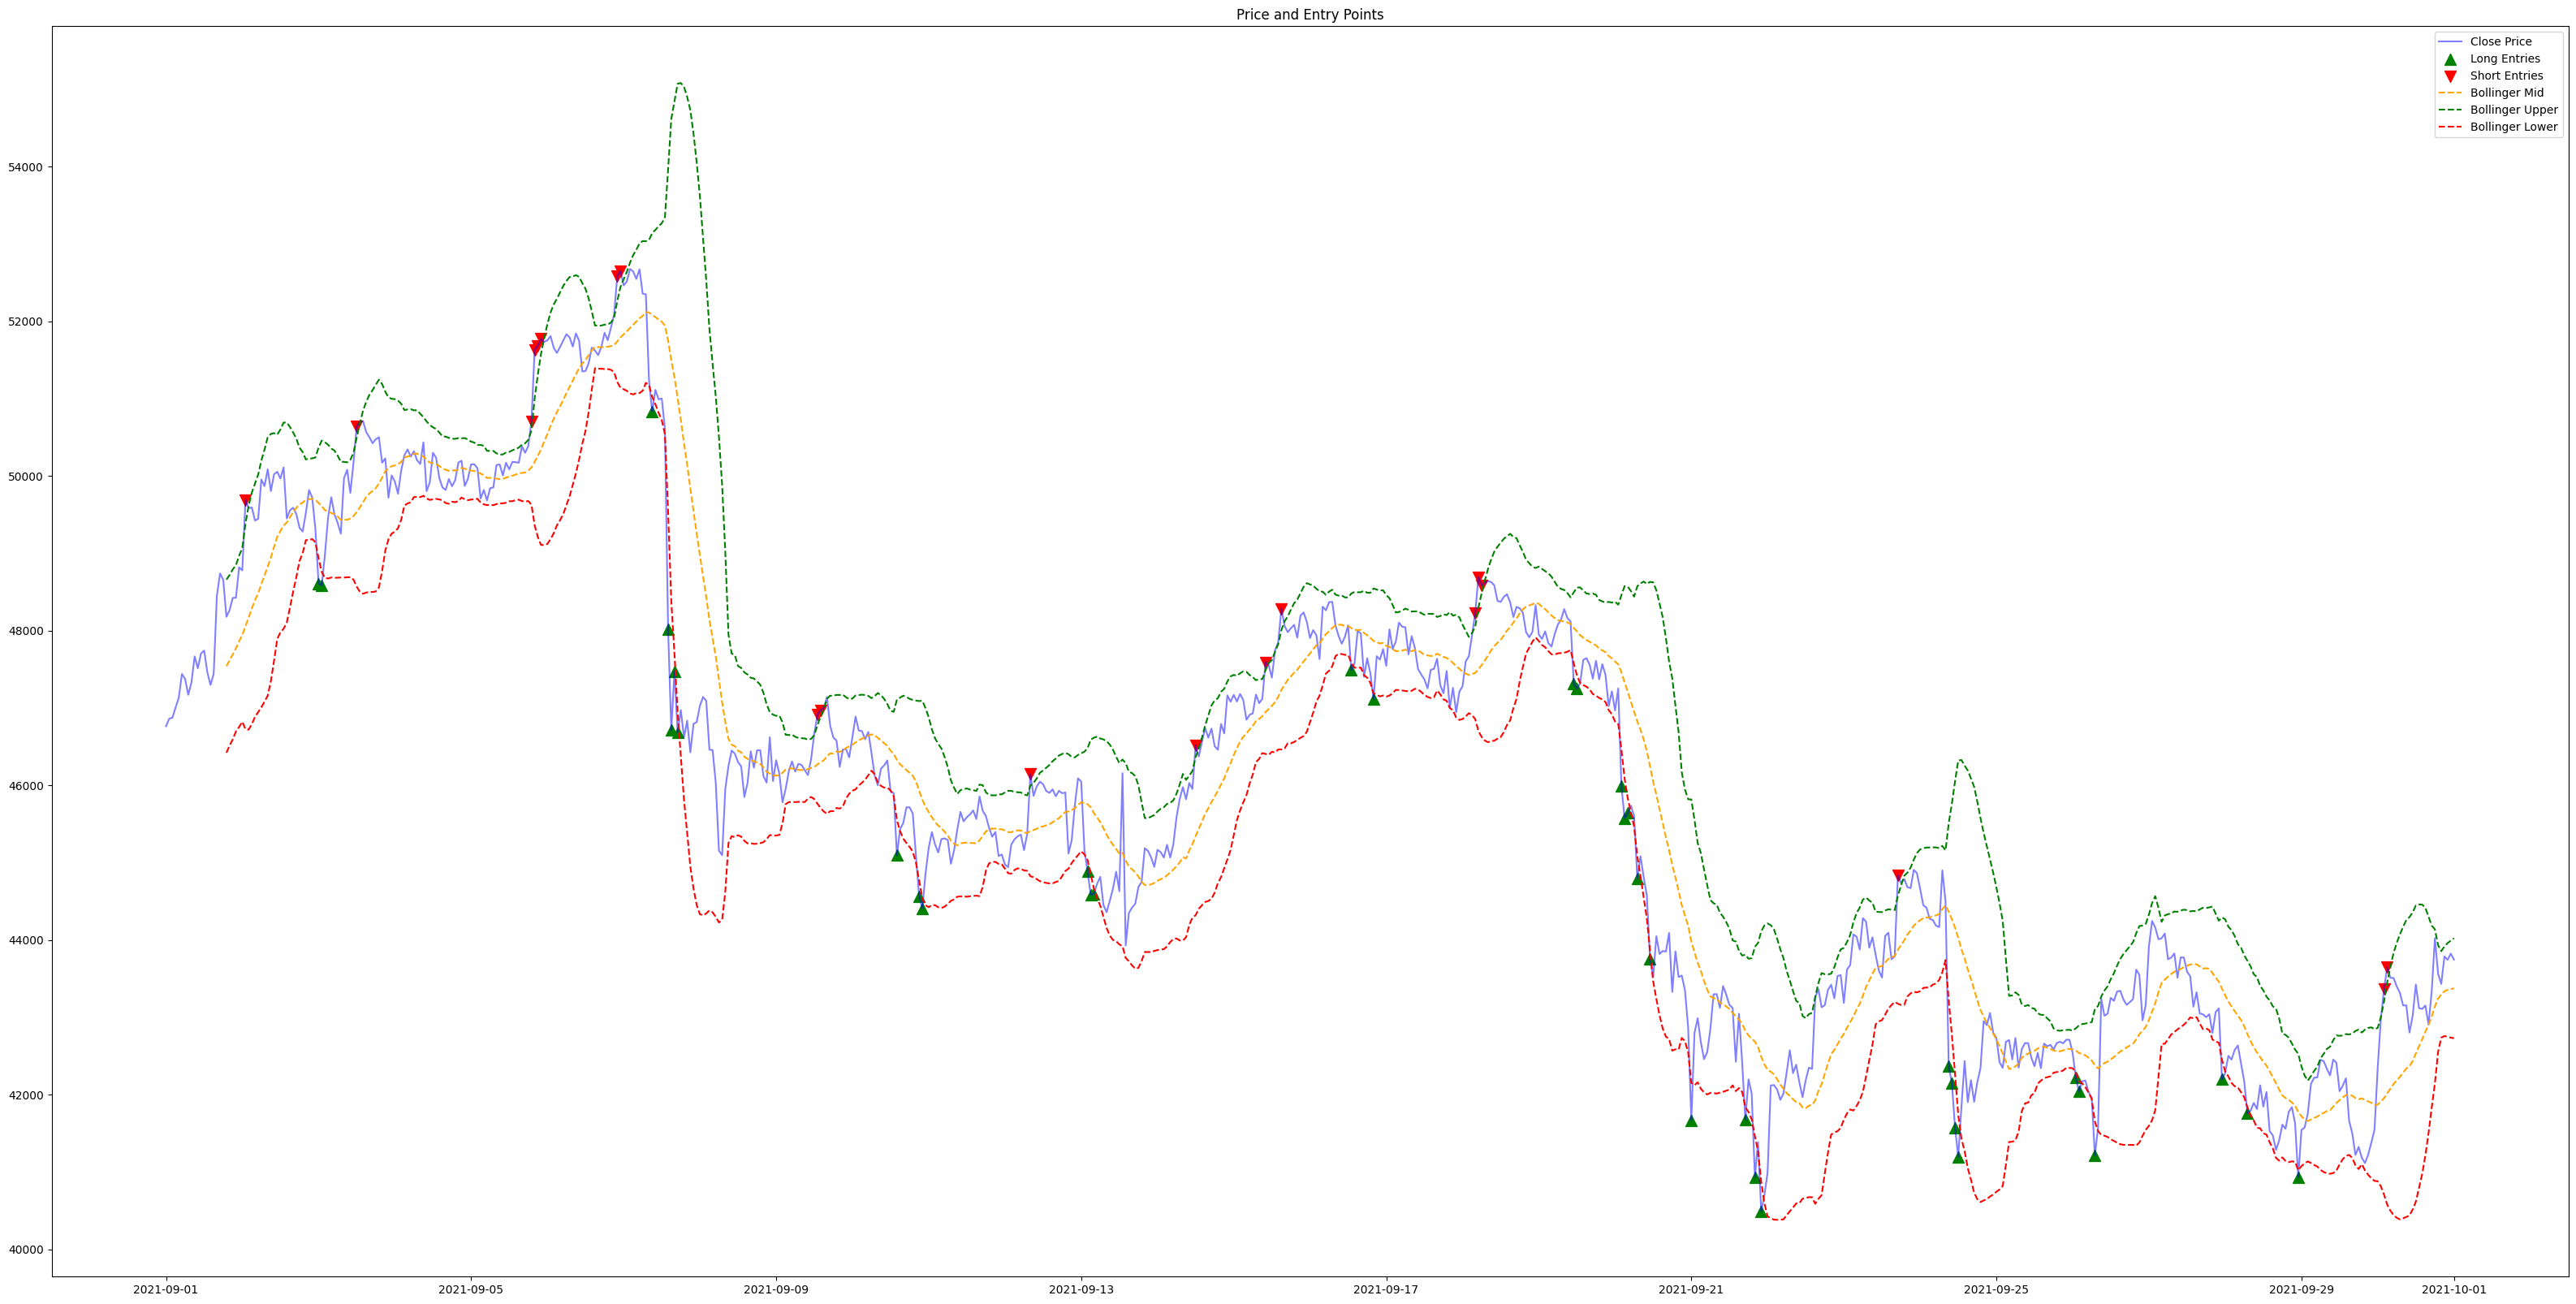

In [12]:
# Calculate Bollinger Bands
data['bollinger_mid'] = ta.volatility.bollinger_mavg(data['close'])
data['bollinger_upper'] = ta.volatility.bollinger_hband(data['close'])
data['bollinger_lower'] = ta.volatility.bollinger_lband(data['close'])

# Define Bollinger Bands trend direction with a minimum margin for the cross-over
margin = 0.001
data['long_entry'] = data['close'] < (data['bollinger_lower'] * (1 - margin))
data['short_entry'] = data['close'] > (data['bollinger_upper'] * (1 + margin))

# Plotting the price and Bollinger Bands for visualization
fig, (ax1) = plt.subplots(1, 1, figsize=(40, 20))

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.plot(data['bollinger_mid'], label='Bollinger Mid', color='orange', linestyle='--')
ax1.plot(data['bollinger_upper'], label='Bollinger Upper', color='green', linestyle='--')
ax1.plot(data['bollinger_lower'], label='Bollinger Lower', color='red', linestyle='--')
ax1.set_title('Price and Entry Points')
ax1.legend()

plt.show()

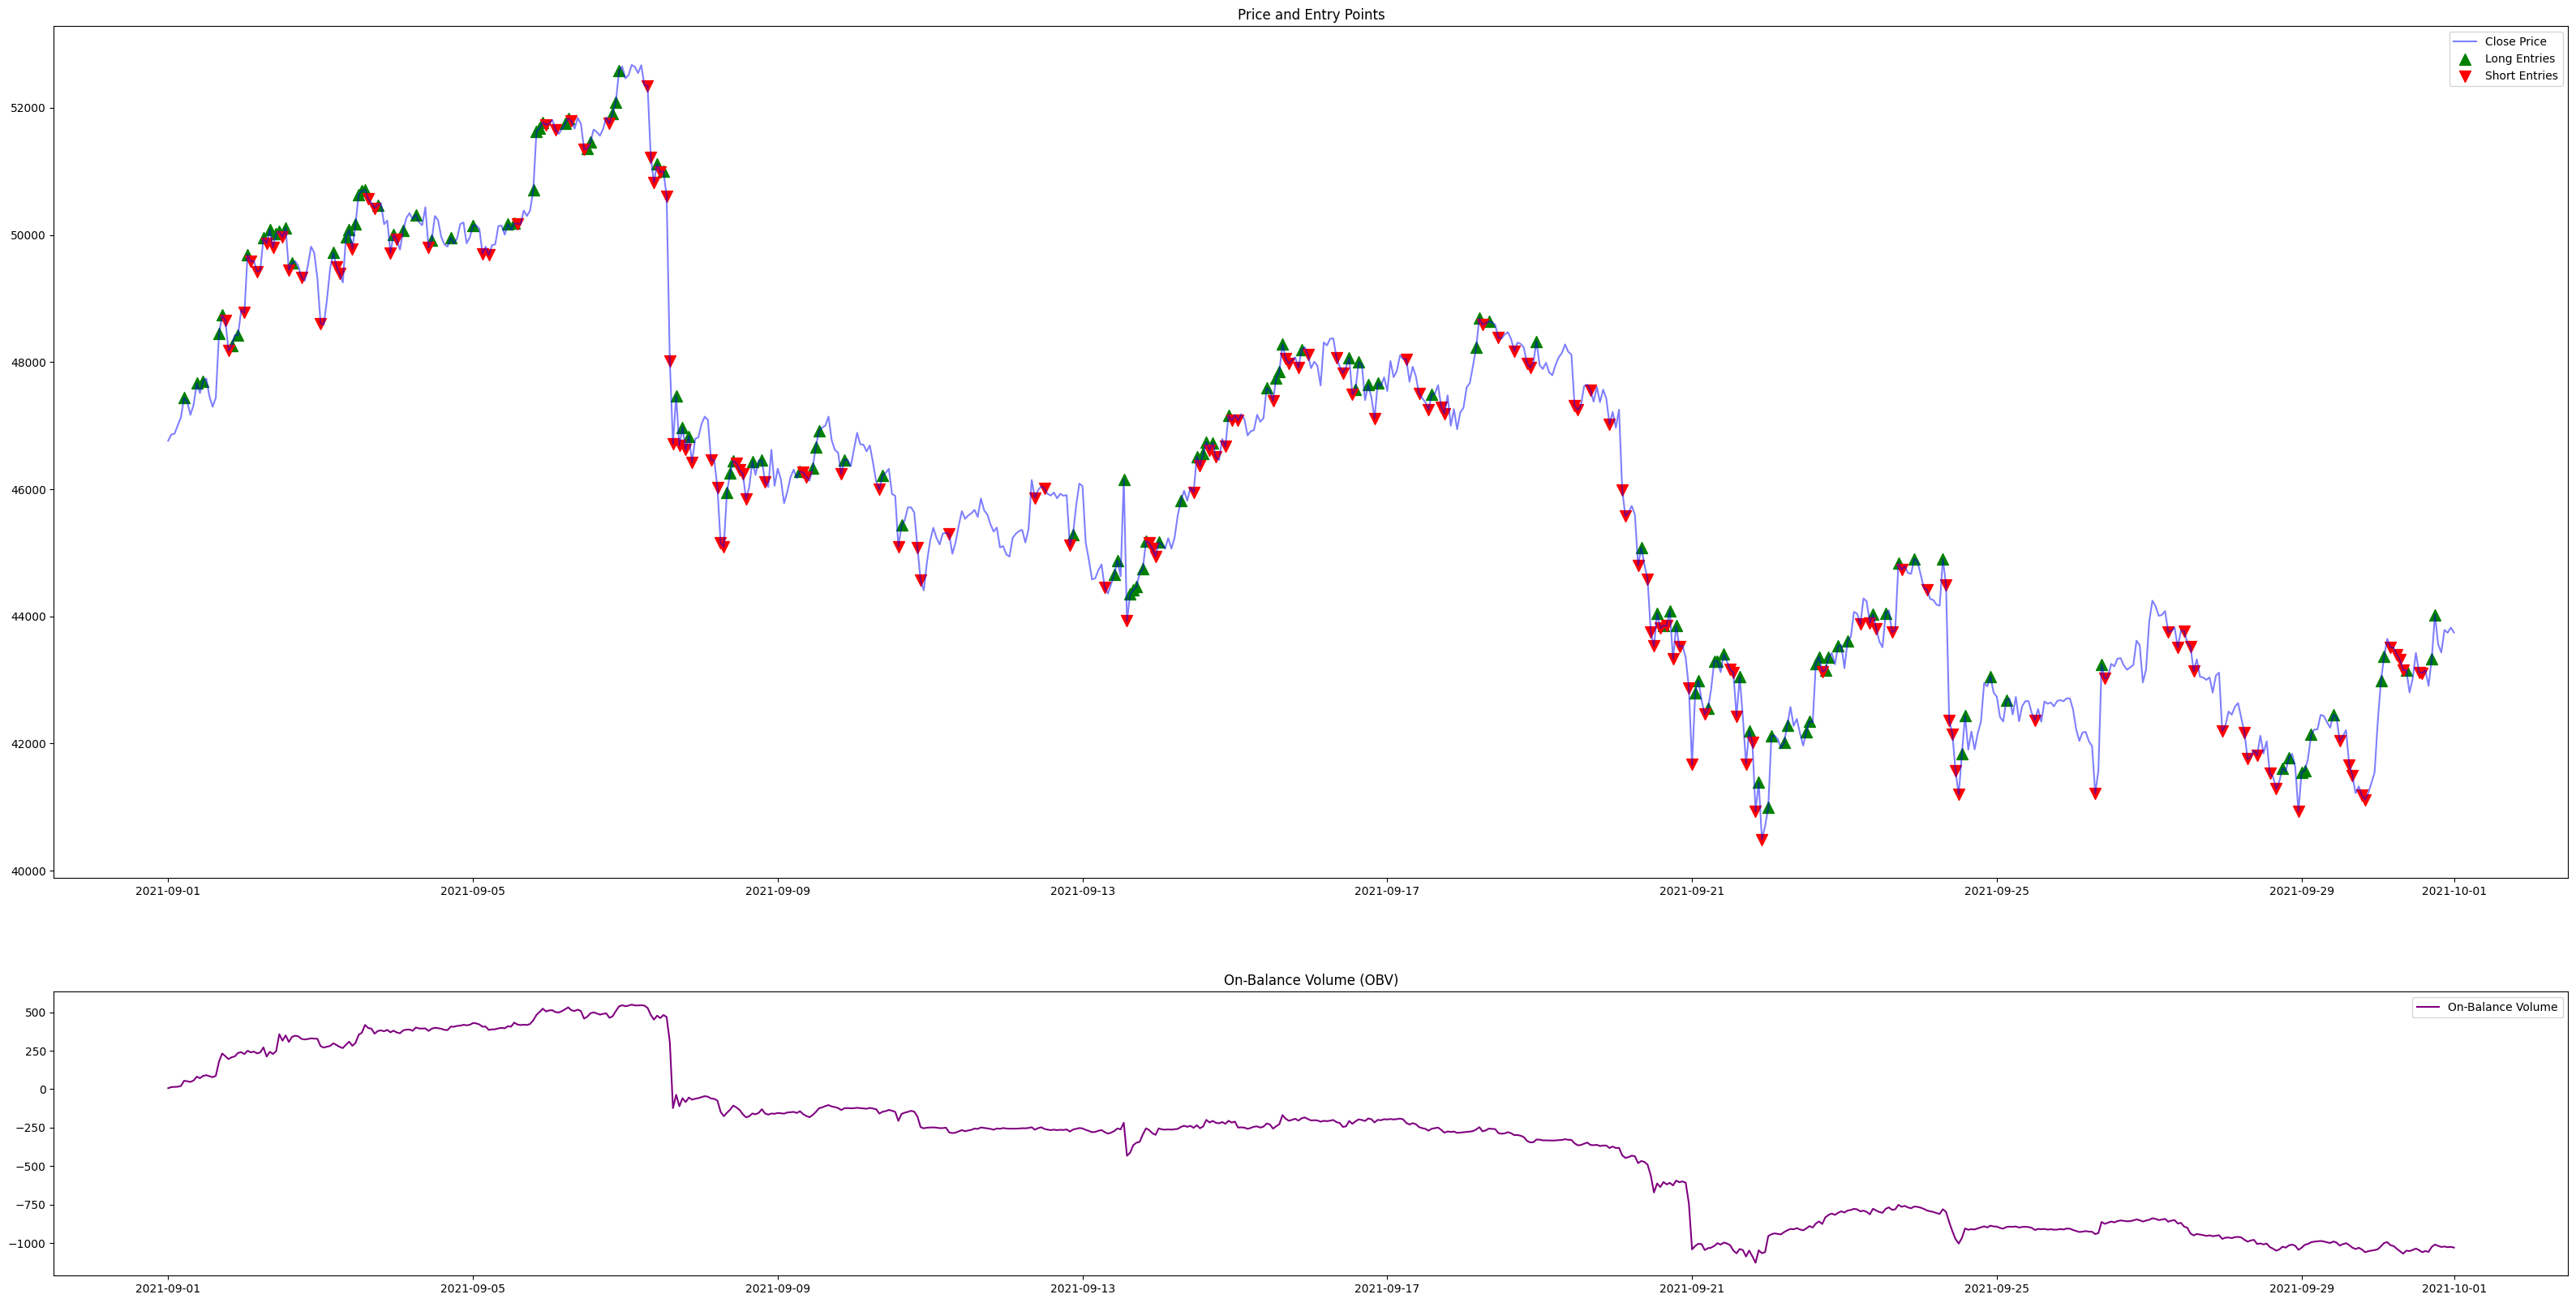

In [13]:
# Calculate On-Balance Volume (OBV)
data['obv'] = ta.volume.on_balance_volume(data['close'], data['volume'])

# Define OBV trend direction with a minimum margin for the cross-over
margin = 10  # Adjust margin based on expected volume scale
data['long_entry'] = (data['obv'] - data['obv'].shift(1)) > margin
data['short_entry'] = (data['obv'] - data['obv'].shift(1)) < -margin

# Plotting the price and OBV for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price and Entry Points')
ax1.legend()

# Plot OBV
ax2.plot(data['obv'], label='On-Balance Volume', color='purple')
ax2.set_title('On-Balance Volume (OBV)')
ax2.legend()

plt.show()

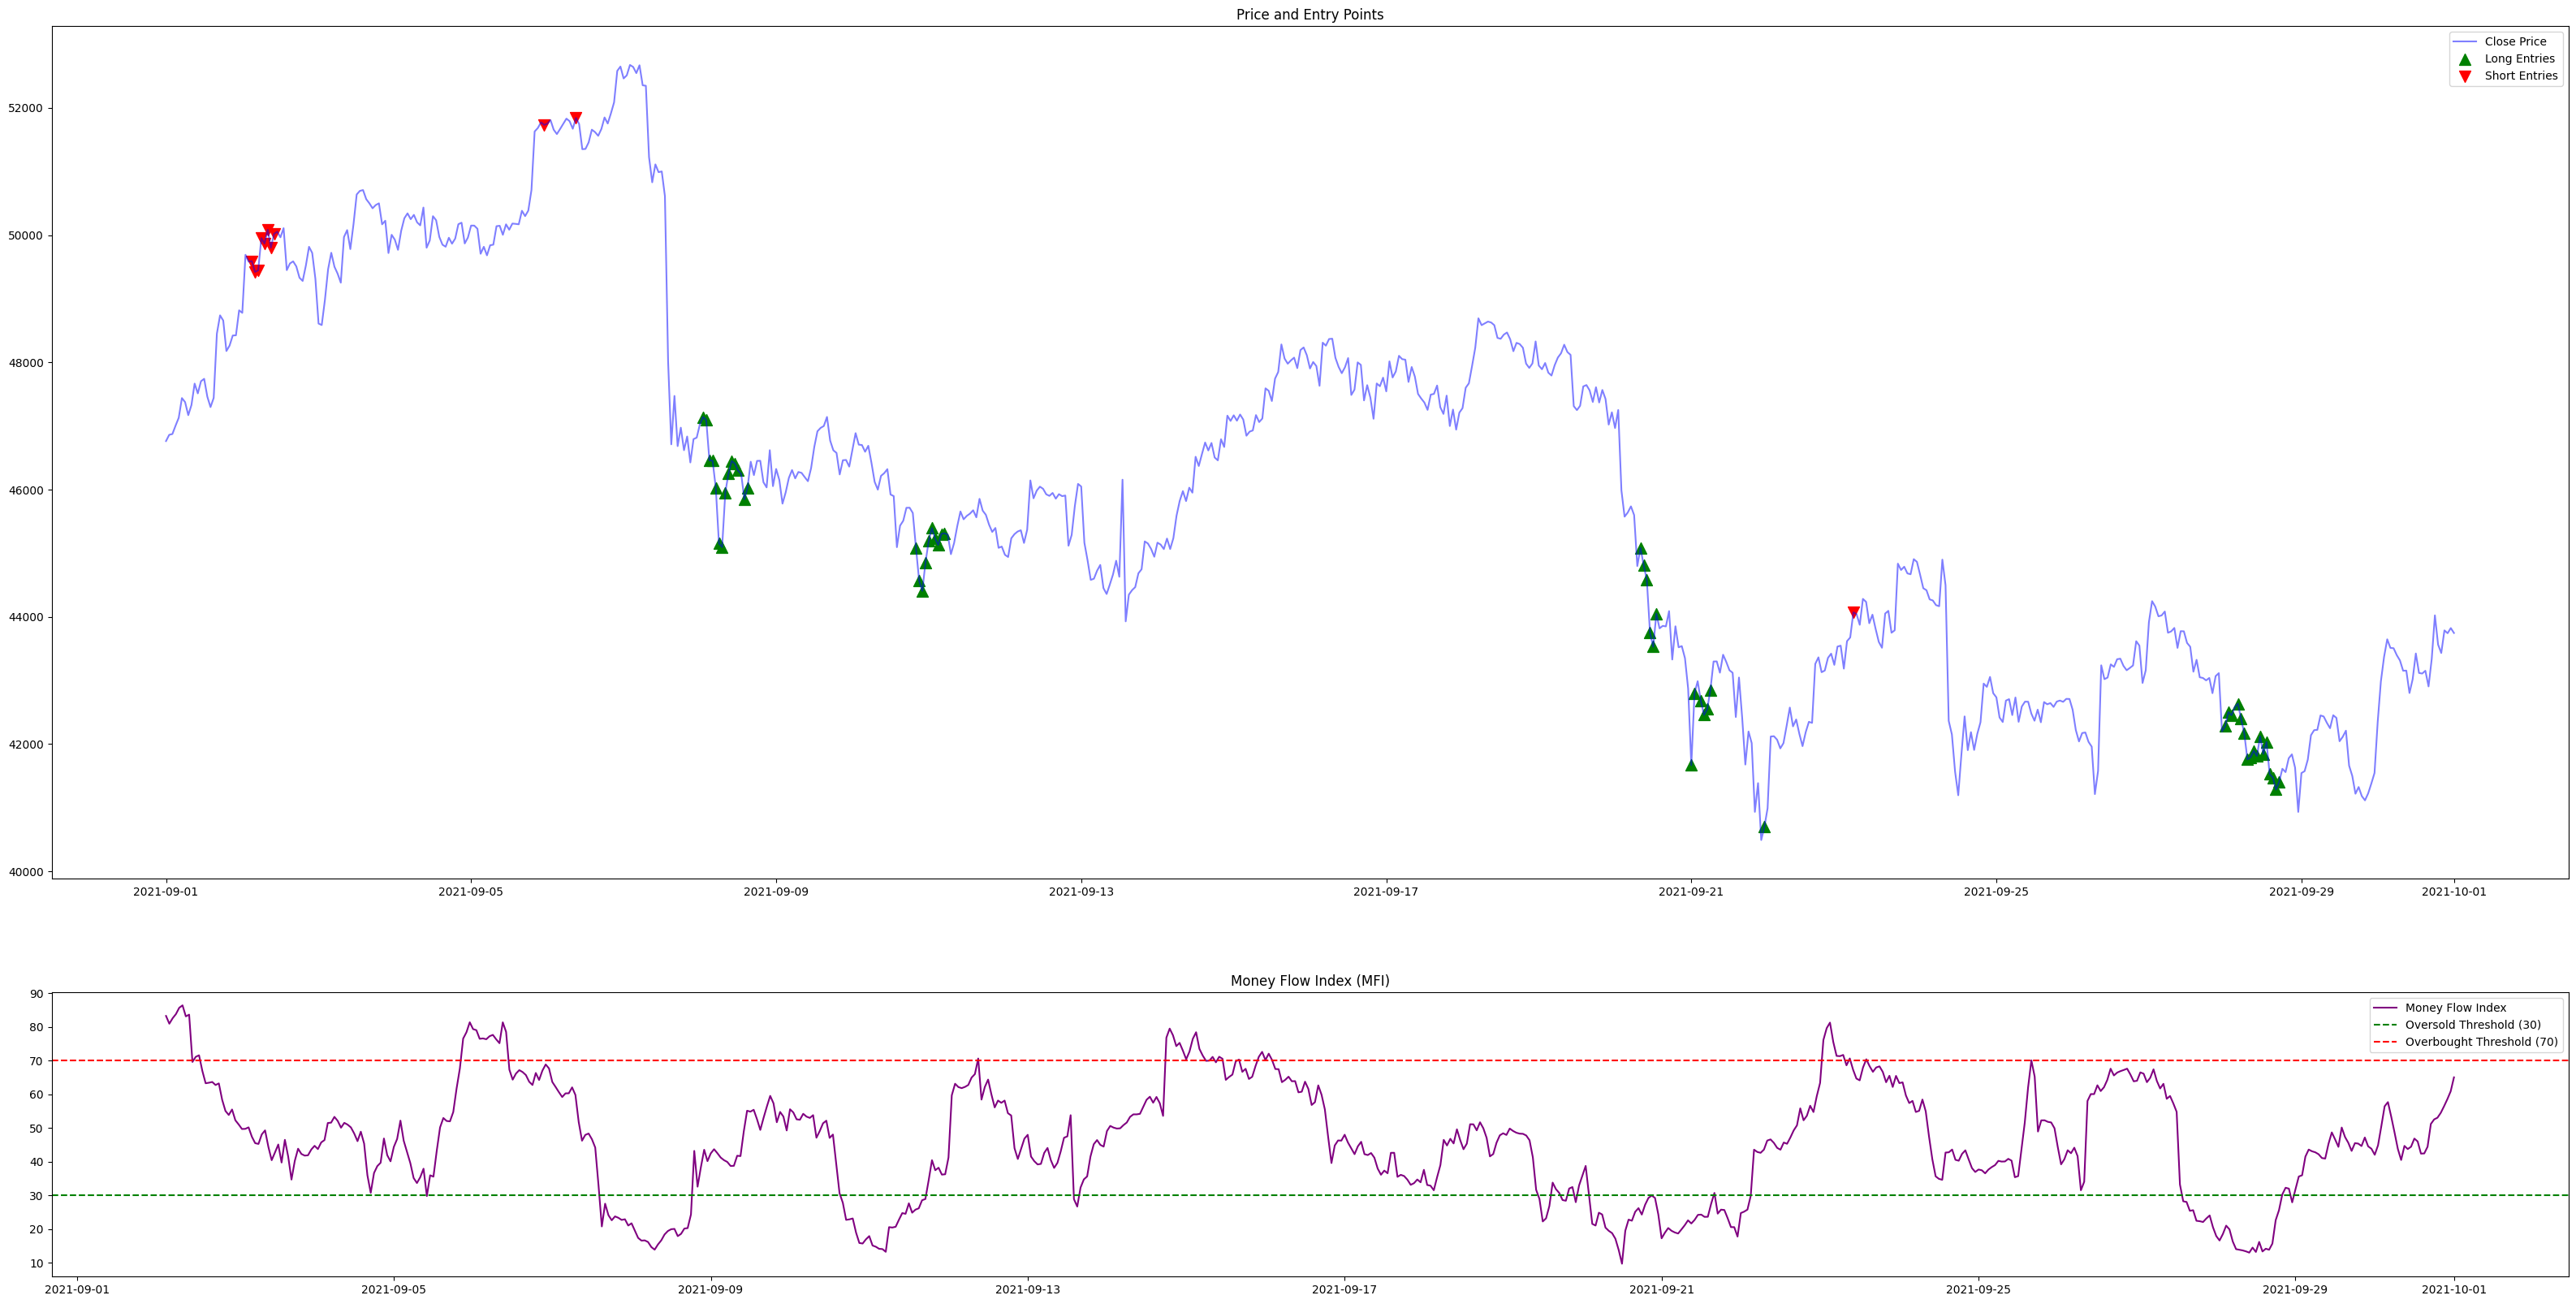

In [14]:
# Calculate Money Flow Index (MFI)
data['mfi'] = ta.volume.money_flow_index(data['high'], data['low'], data['close'], data['volume'], 28)

# Define MFI trend direction with a minimum margin for the cross-over
margin = 0  # Adjust margin based on expected MFI scale (0-100)
data['long_entry'] = data['mfi'] < (20 - margin)  # Oversold region entry
data['short_entry'] = data['mfi'] > (80 + margin)  # Overbought region exit

# Plotting the price and MFI for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price and Entry Points')
ax1.legend()

# Plot MFI
ax2.plot(data['mfi'], label='Money Flow Index', color='purple')
ax2.axhline(30, color='green', linestyle='--', label='Oversold Threshold (30)')
ax2.axhline(70, color='red', linestyle='--', label='Overbought Threshold (70)')
ax2.set_title('Money Flow Index (MFI)')
ax2.legend()

plt.show()

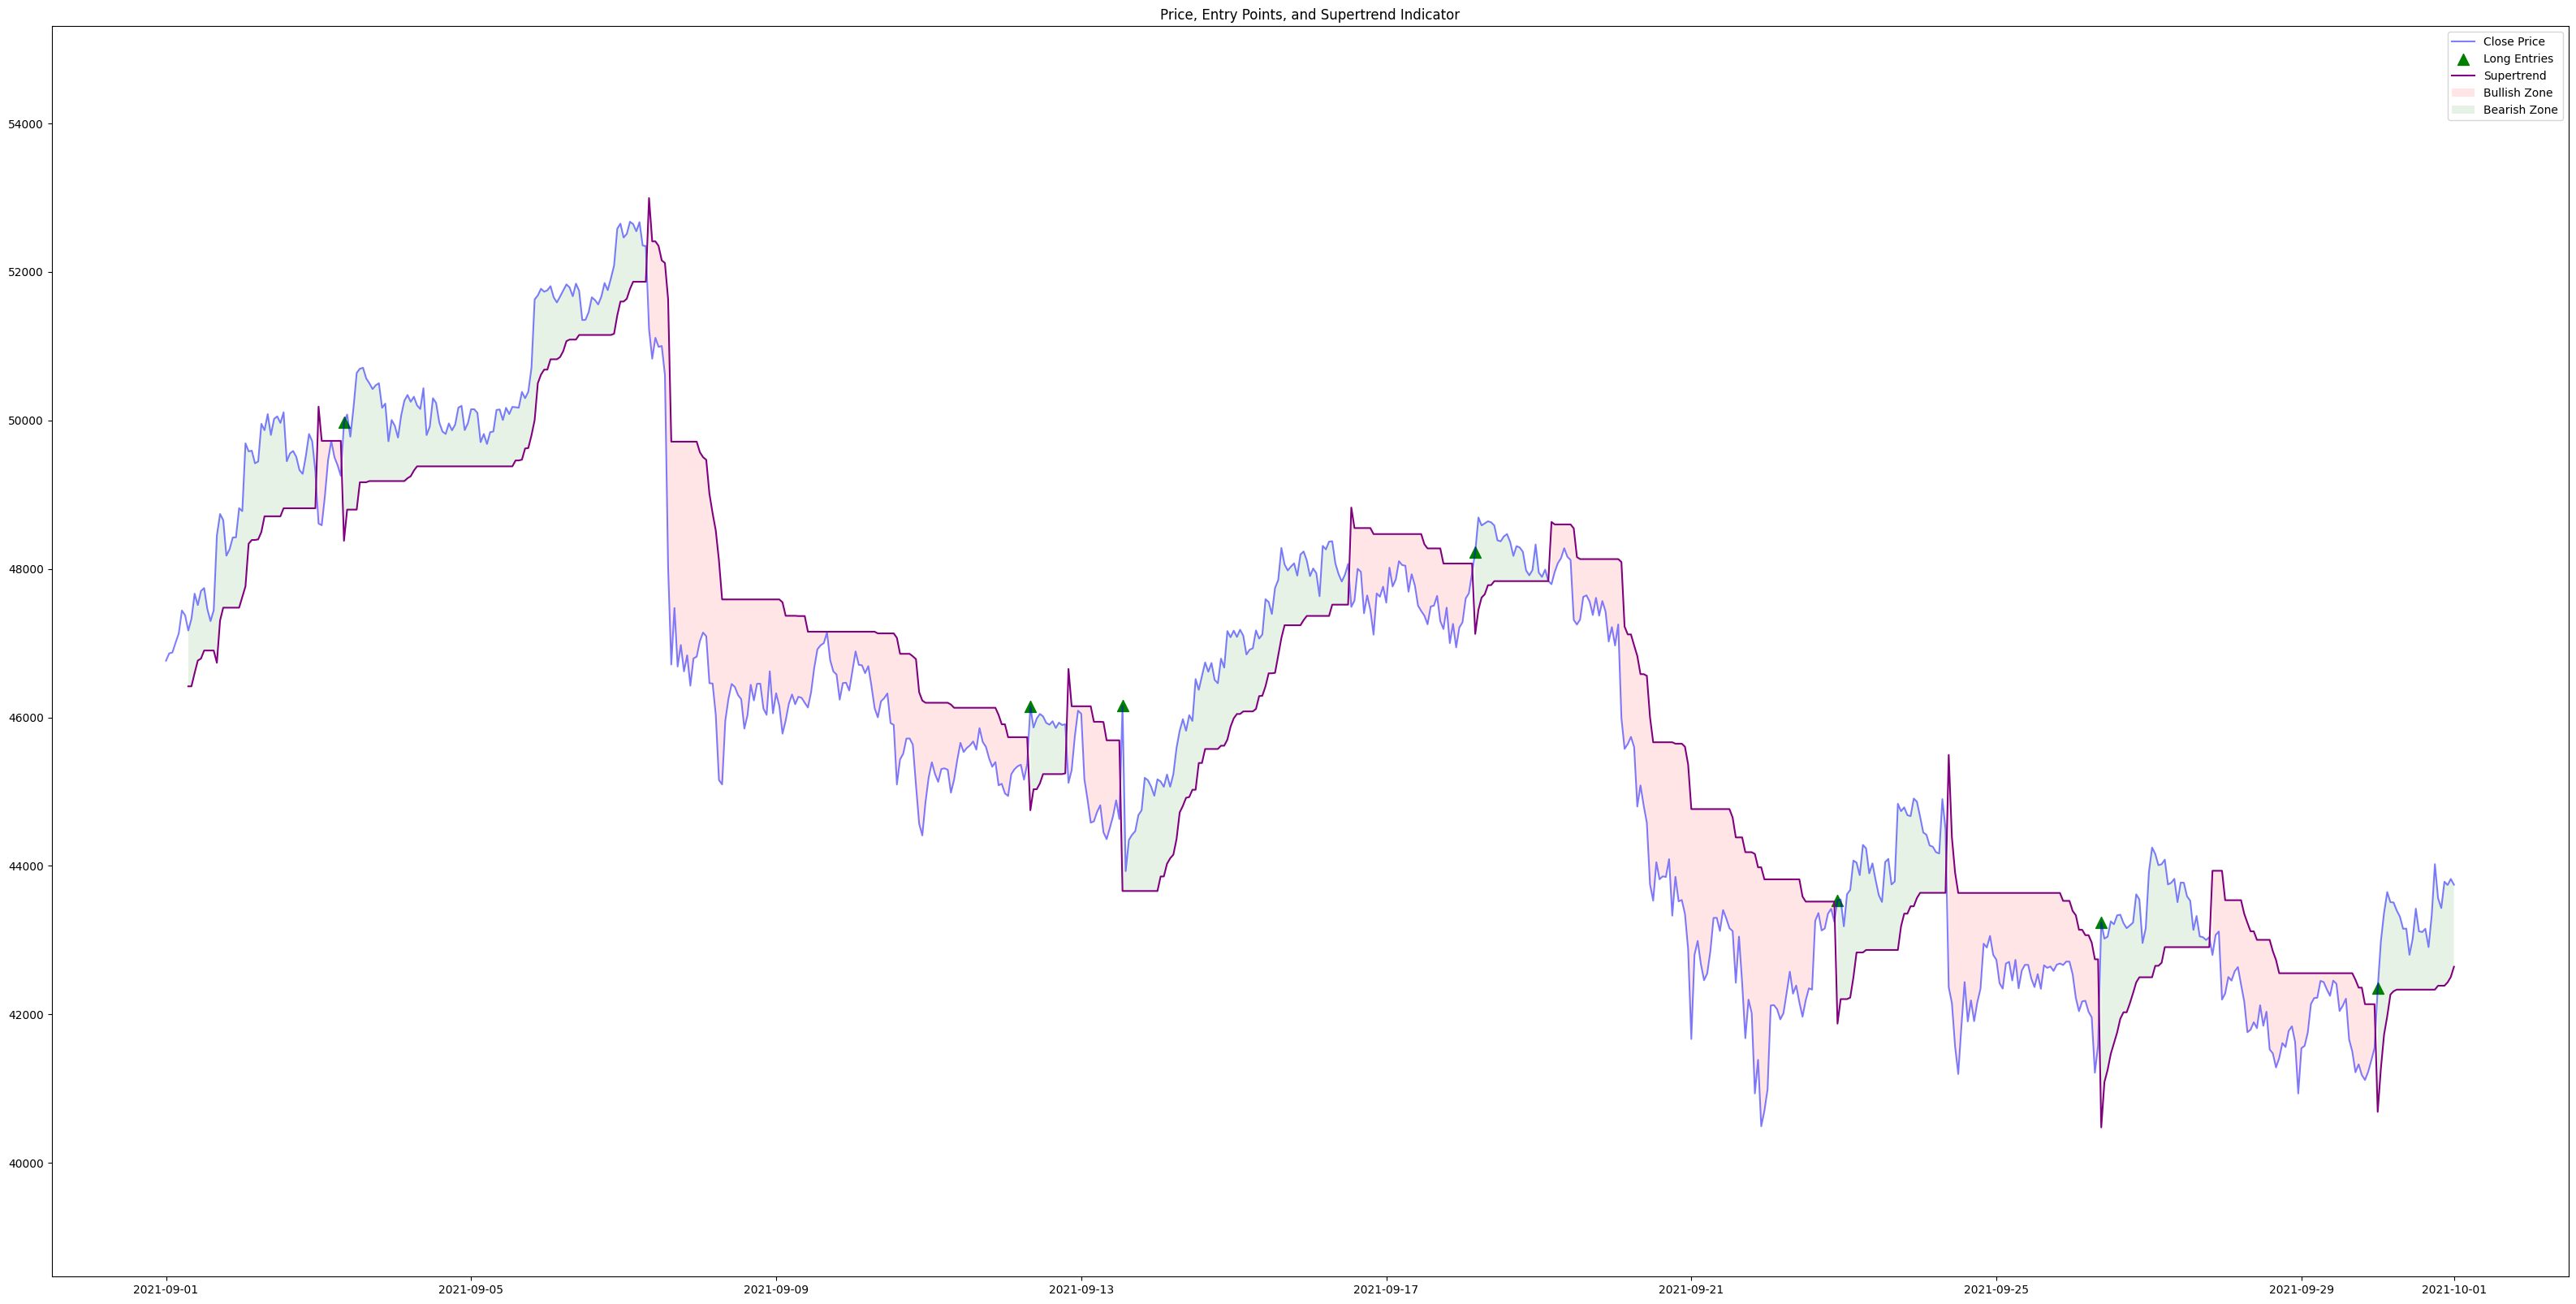

In [15]:
# Calculate Supertrend using pandas_ta
import pandas_ta as pta

supertrend_data = pta.supertrend(data['high'], data['low'], data['close'], length=7, multiplier=3)
data['supertrend'] = supertrend_data['SUPERT_7_3.0']
data['supertrend_minus_one'] = data['supertrend'].shift(1)
data['supertrend_minus_two'] = data['supertrend'].shift(2)

data['close_minus_one'] = data['close'].shift(1)
data['close_minus_two'] = data['close'].shift(2)

# Define Supertrend trend direction for entry and exit
data['long_entry'] = (data['supertrend'] <= data['close']) & (data['supertrend_minus_one'] > data['close_minus_one'])
data['short_entry'] = (data['supertrend'] >= data['close']) & (data['supertrend_minus_one'] < data['close_minus_one'])

# Plotting the price and Supertrend for visualization
fig, ax1 = plt.subplots(1, 1, figsize=(40, 20))

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
#ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)

# Overlay Supertrend on the same axis as price
ax1.plot(data['supertrend'], label='Supertrend', color='purple')
ax1.fill_between(data.index, data['supertrend'], data['close'], where=data['supertrend'] > data['close'], facecolor='red', alpha=0.1, label='Bullish Zone')
ax1.fill_between(data.index, data['supertrend'], data['close'], where=data['supertrend'] < data['close'], facecolor='green', alpha=0.1, label='Bearish Zone')

ax1.set_title('Price, Entry Points, and Supertrend Indicator')
ax1.legend()

ax1.set_ylim(data['close'].min() * .95, data['close'].max() * 1.05)  # Set y-axis scale from 35000 to 50000

plt.show()



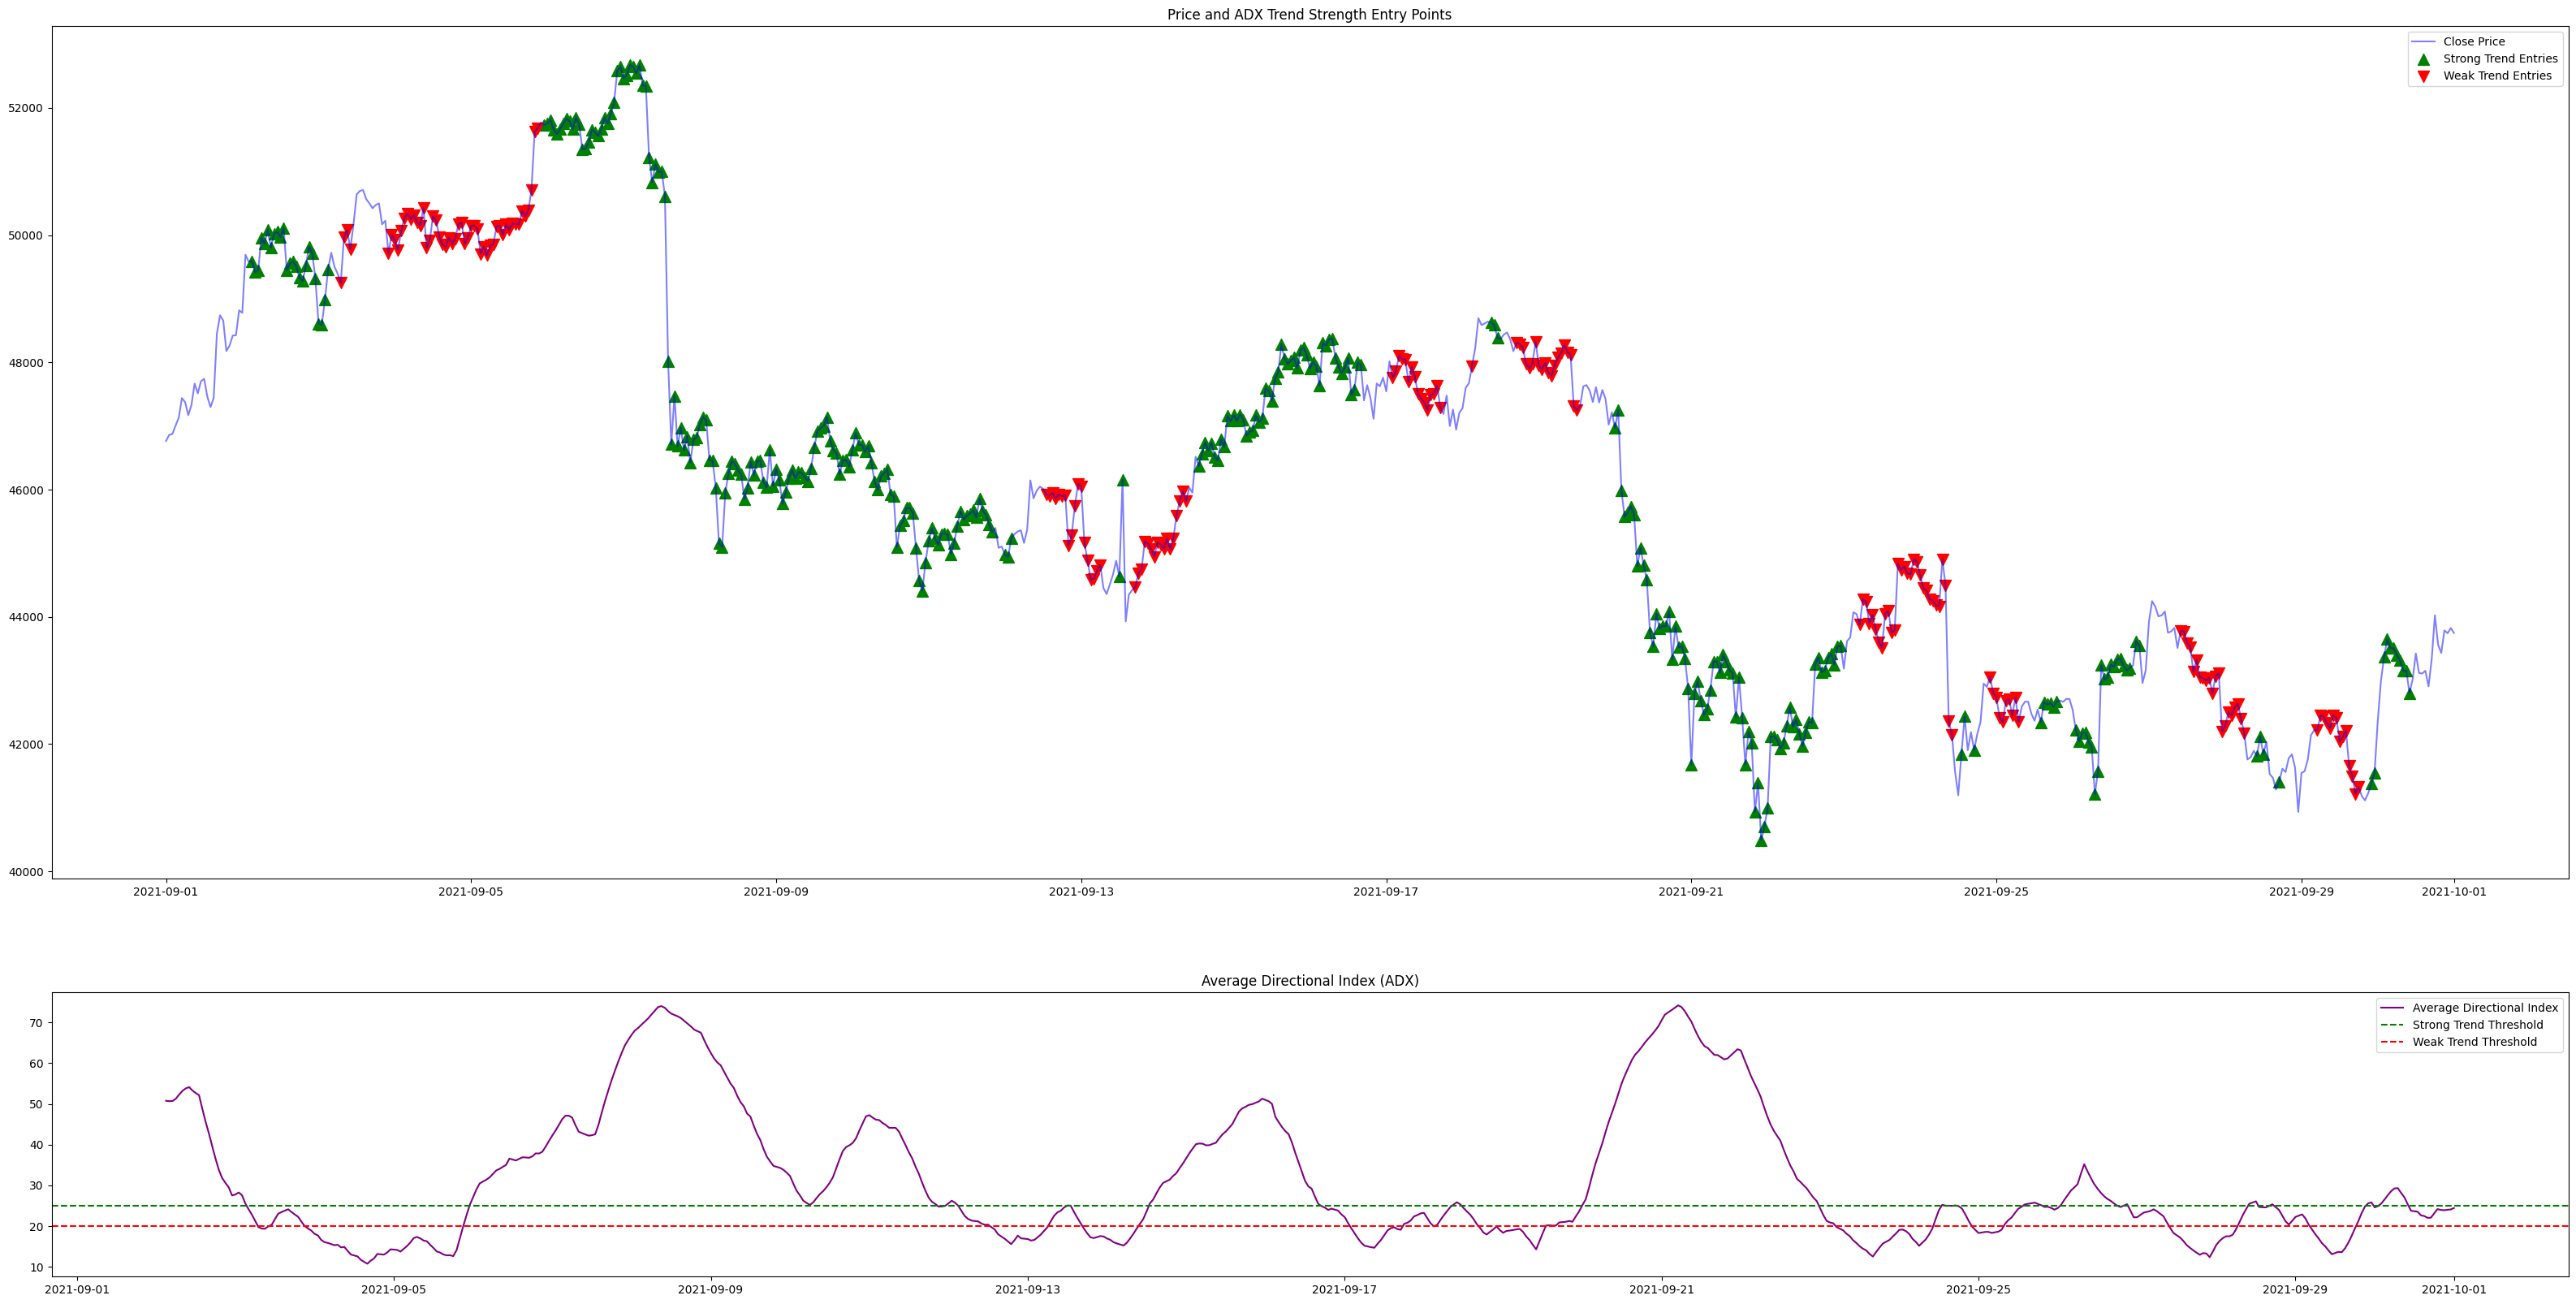

In [16]:
# Calculate ADX using pandas_ta
data['adx'] = pta.adx(data['high'], data['low'], data['close'], length=14)['ADX_14']

# Define ADX trend strength thresholds
adx_strong = 25
adx_weak = 20

# Define entry points based on ADX strength
data['strong_trend_entry'] = data['adx'] > adx_strong
data['weak_trend_entry'] = data['adx'] < adx_weak

# Plotting the price and ADX for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['strong_trend_entry']], data['close'][data['strong_trend_entry']], label='Strong Trend Entries', color='green', marker='^', s=100)
ax1.scatter(data.index[data['weak_trend_entry']], data['close'][data['weak_trend_entry']], label='Weak Trend Entries', color='red', marker='v', s=100)
ax1.set_title('Price and ADX Trend Strength Entry Points')
ax1.legend()

# Plot ADX
ax2.plot(data['adx'], label='Average Directional Index', color='purple')
ax2.axhline(adx_strong, color='green', linestyle='--', label='Strong Trend Threshold')
ax2.axhline(adx_weak, color='red', linestyle='--', label='Weak Trend Threshold')
ax2.set_title('Average Directional Index (ADX)')
ax2.legend()

plt.show()


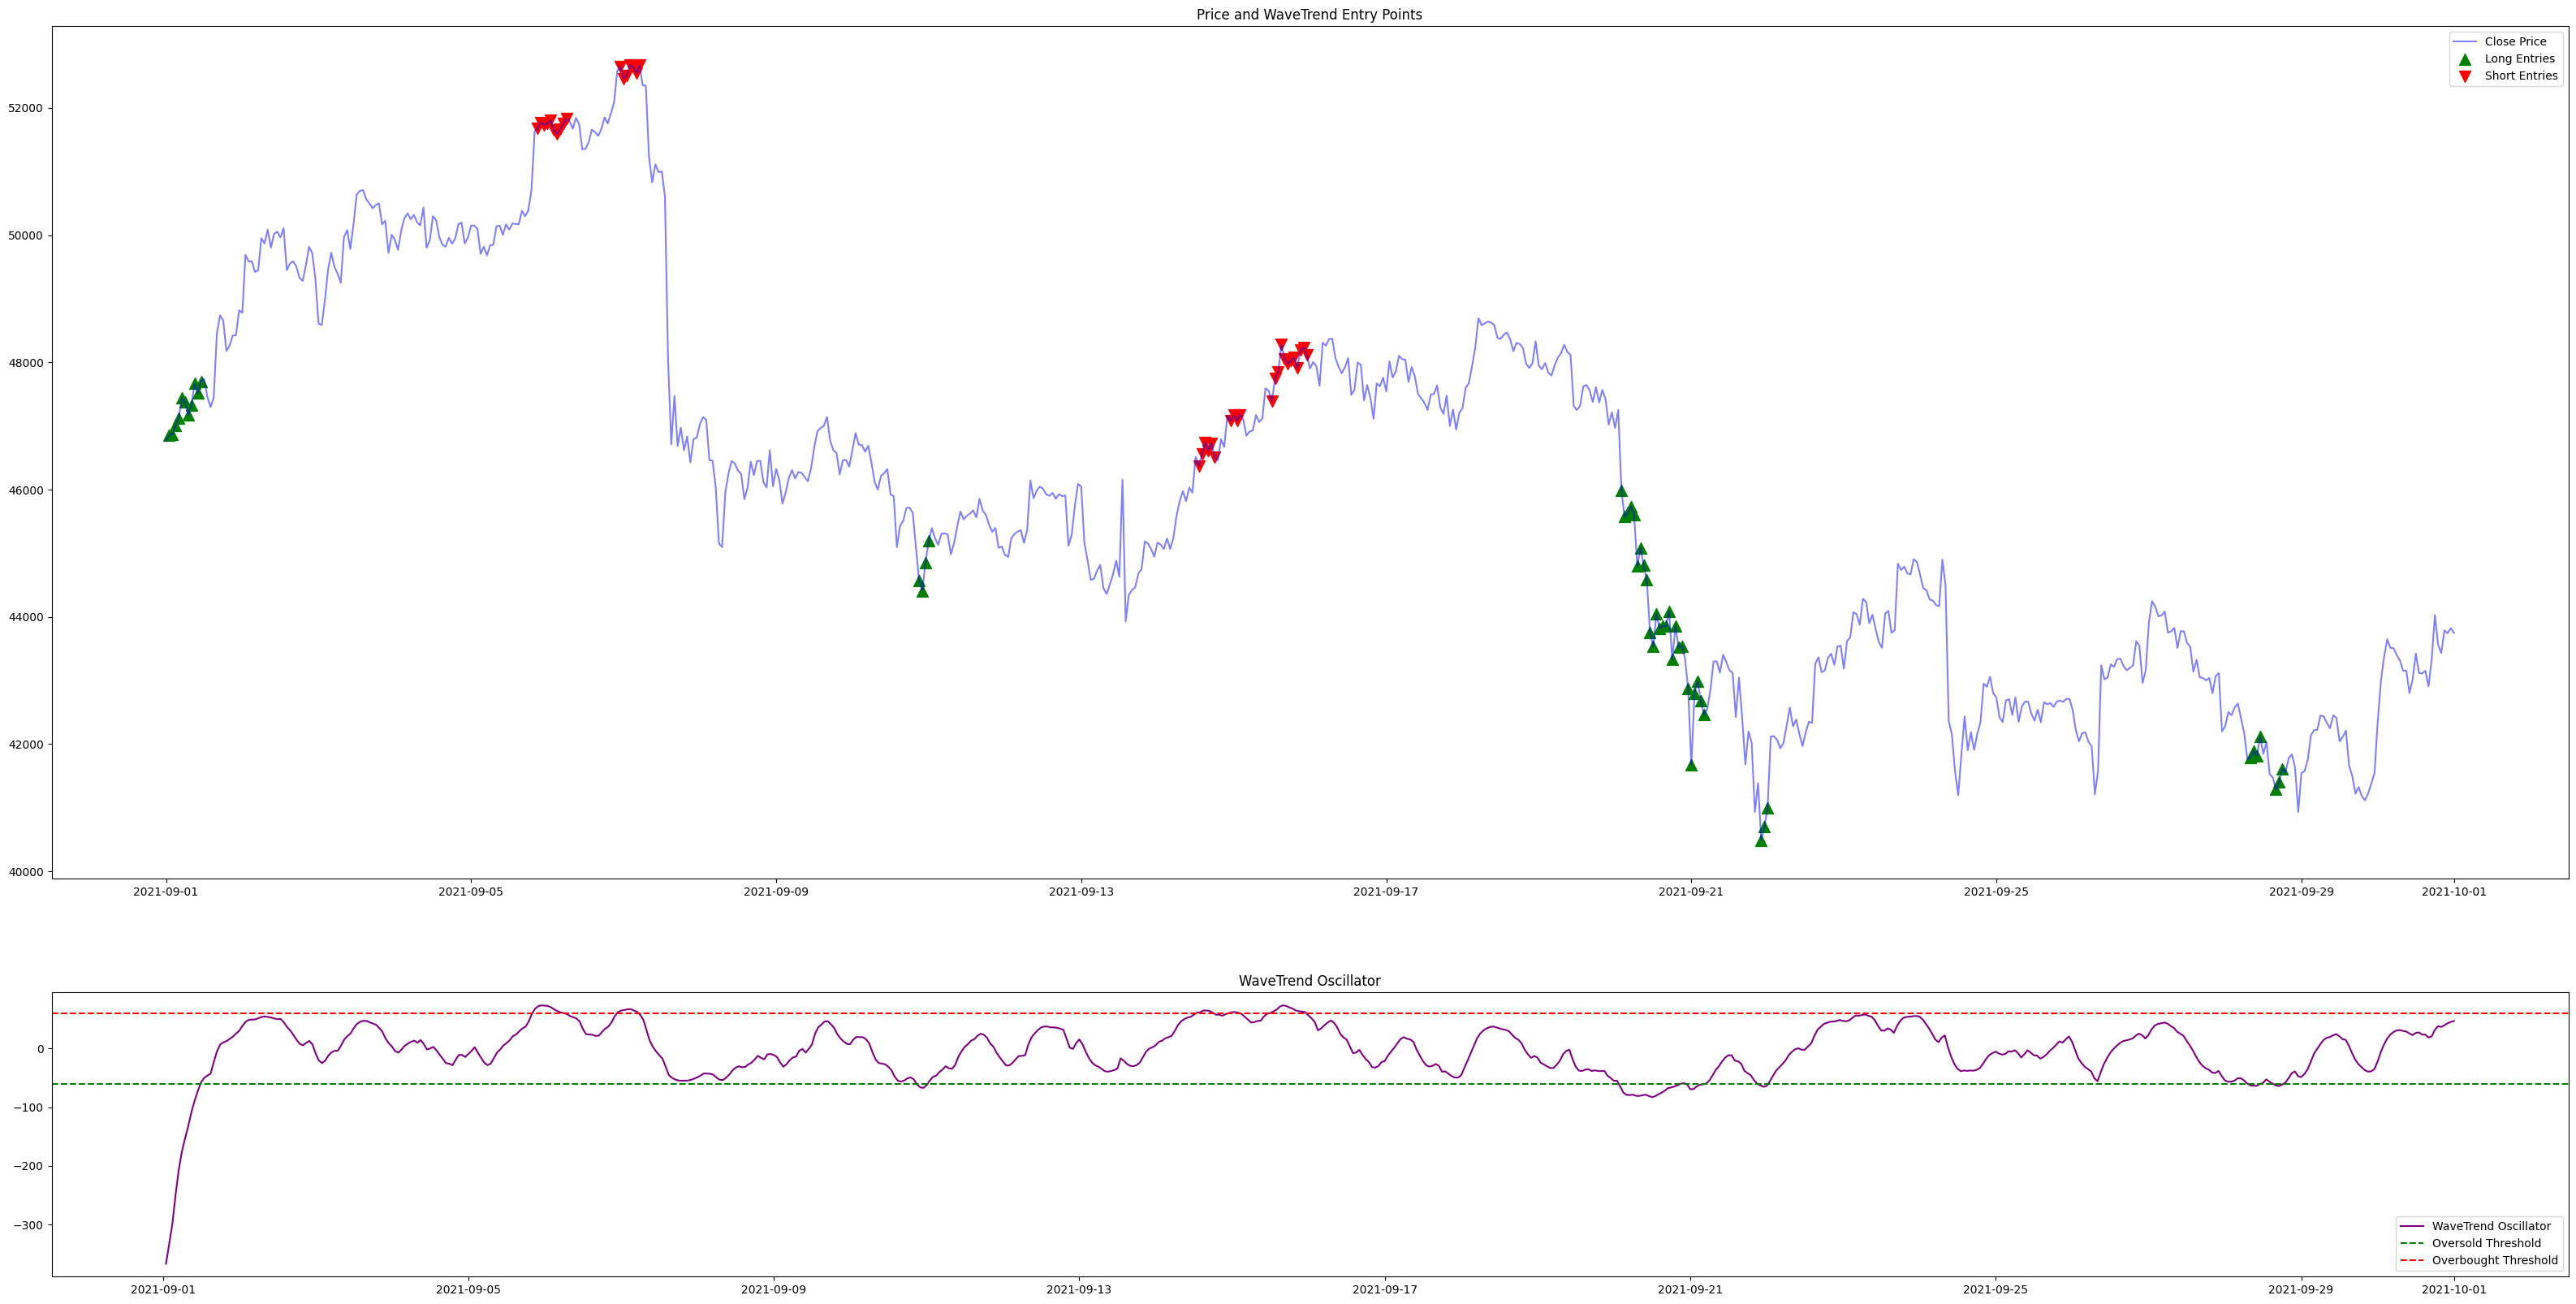

In [17]:
# Calculate WaveTrend Oscillator
def calculate_wavetrend(data, n1=10, n2=21):
    ap = (data['high'] + data['low'] + data['close']) / 3
    esa = ap.ewm(span=n1, adjust=False).mean()
    d = (ap - esa).abs().ewm(span=n1, adjust=False).mean()
    ci = (ap - esa) / (0.015 * d)
    tci = ci.ewm(span=n2, adjust=False).mean()
    return tci

data['wavetrend'] = calculate_wavetrend(data)

# Define WaveTrend overbought and oversold regions
overbought = 60
oversold = -60
data['long_entry'] = data['wavetrend'] < oversold
data['short_entry'] = data['wavetrend'] > overbought

# Plotting the price and WaveTrend for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price and WaveTrend Entry Points')
ax1.legend()

# Plot WaveTrend
ax2.plot(data['wavetrend'], label='WaveTrend Oscillator', color='purple')
ax2.axhline(oversold, color='green', linestyle='--', label='Oversold Threshold')
ax2.axhline(overbought, color='red', linestyle='--', label='Overbought Threshold')
ax2.set_title('WaveTrend Oscillator')
ax2.legend()

plt.show()

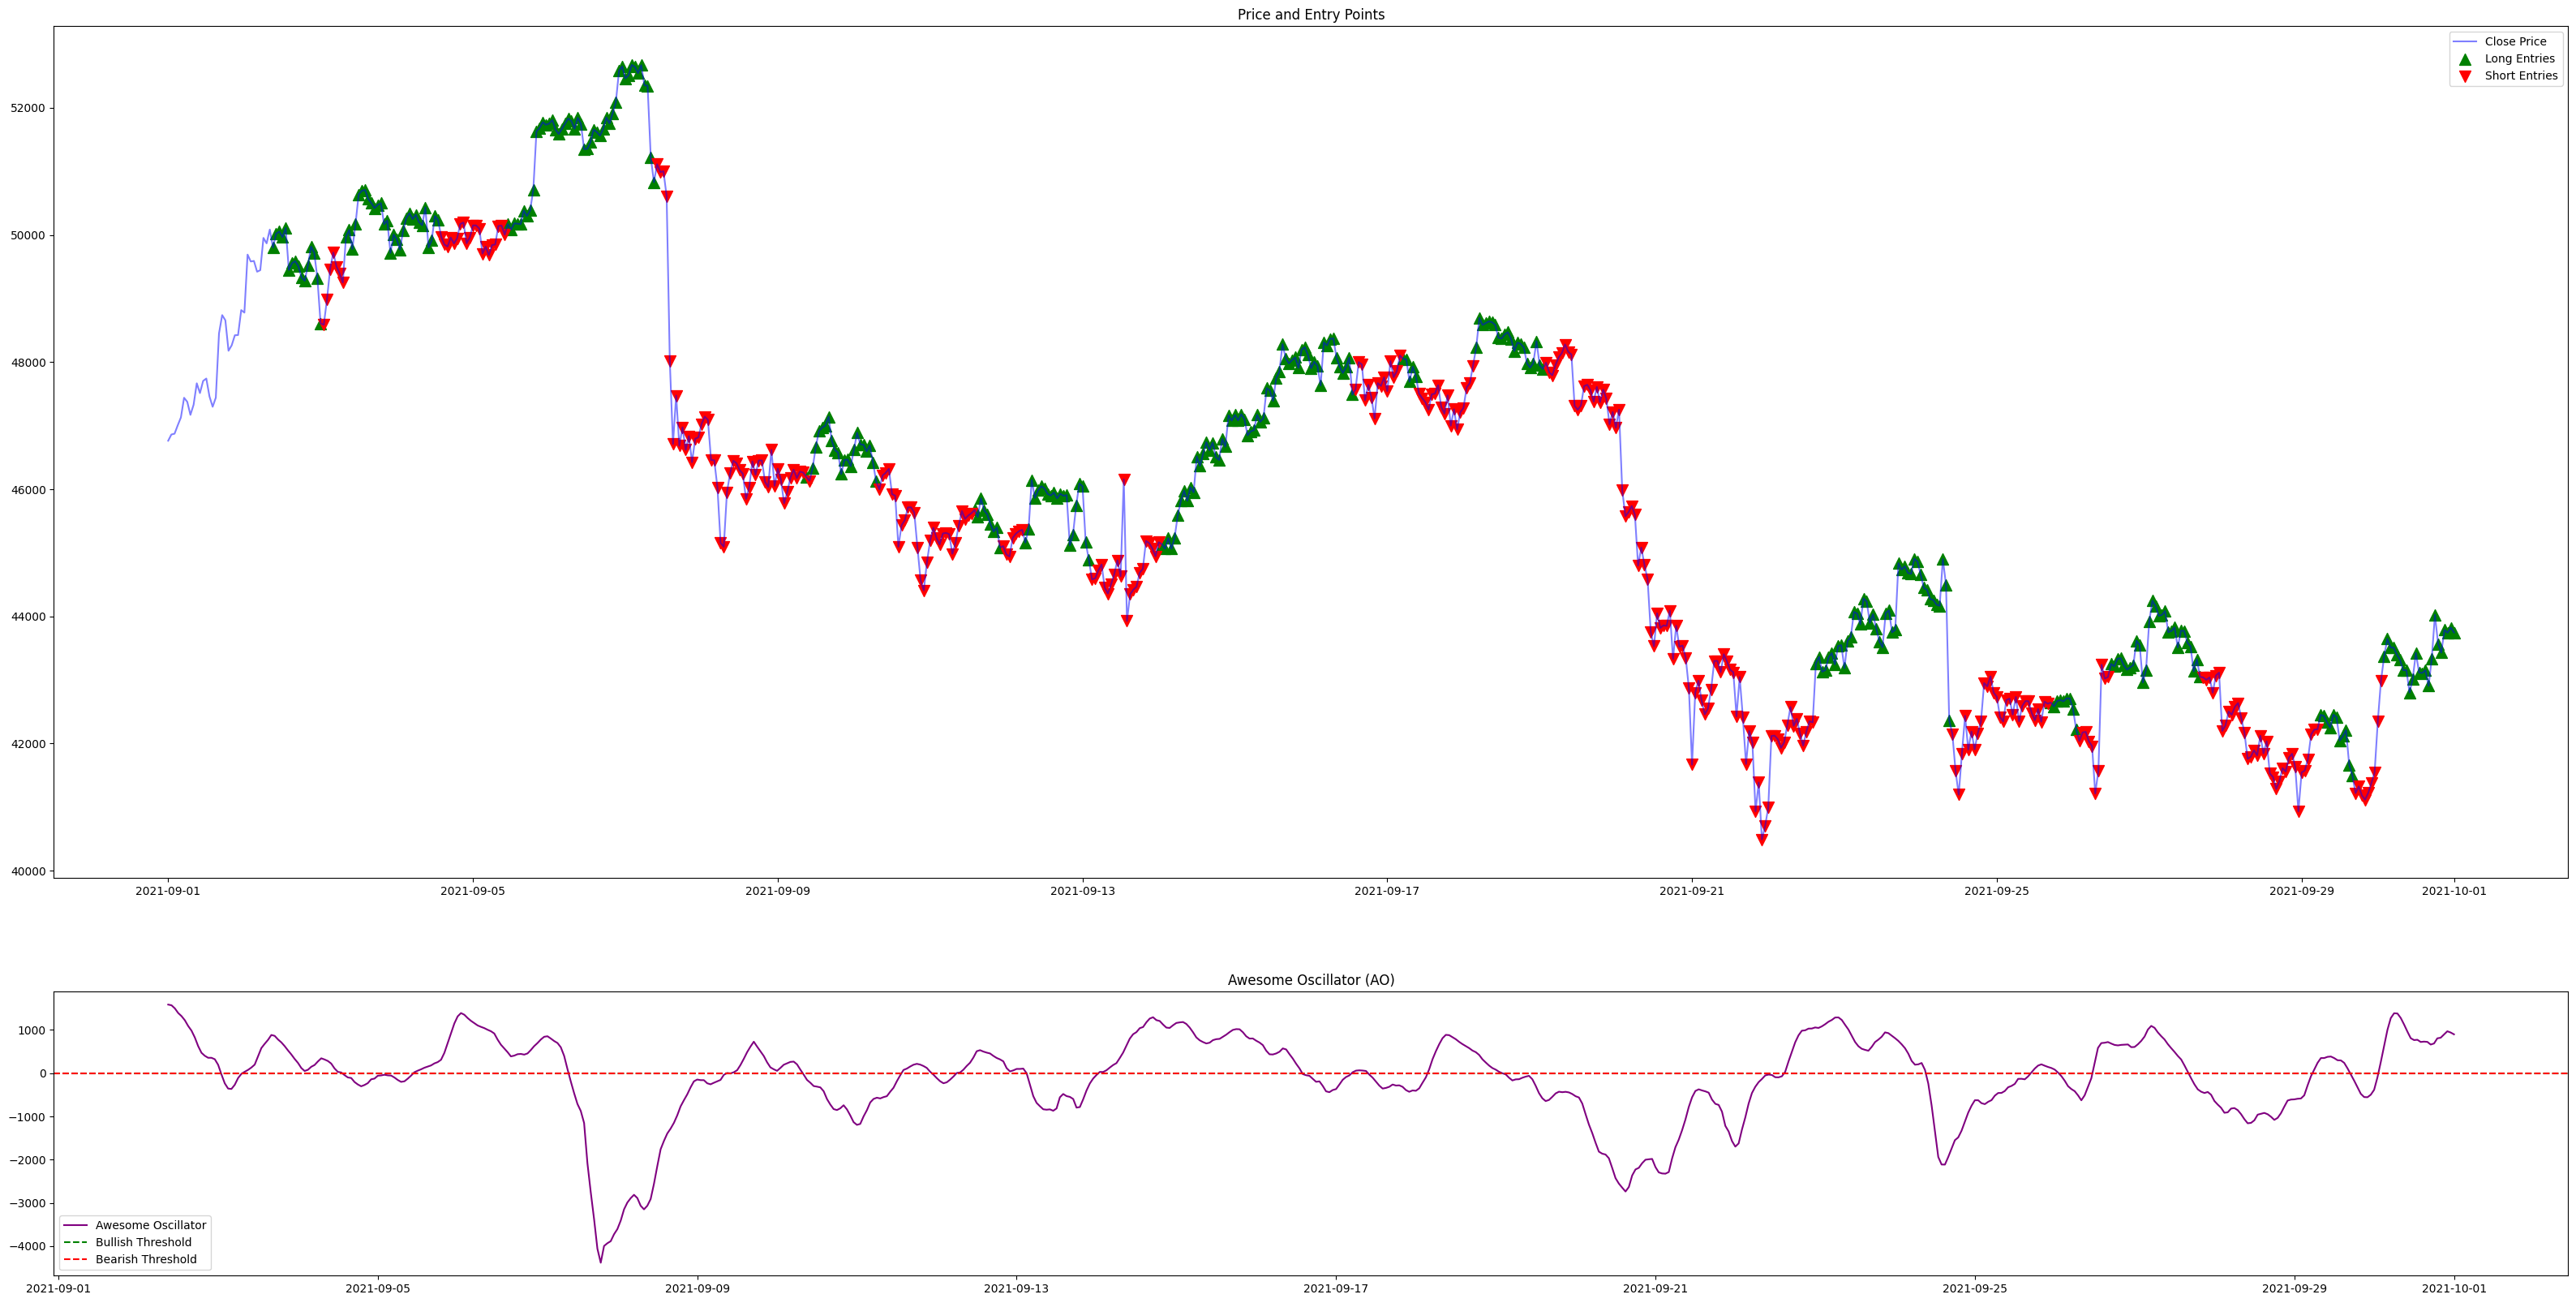

In [18]:
# Calculate Awesome Oscillator (AO)
data['ao'] = ta.momentum.awesome_oscillator(data['high'], data['low'], 5, 34)

# Define AO trend direction with a minimum margin for the cross-over
margin = 0  # Adjust margin based on expected AO scale
data['long_entry'] = data['ao'] > margin  # Bullish crossover
data['short_entry'] = data['ao'] < -margin  # Bearish crossover

# Plotting the price and AO for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price and Entry Points')
ax1.legend()

# Plot AO
ax2.plot(data['ao'], label='Awesome Oscillator', color='purple')
ax2.axhline(margin, color='green', linestyle='--', label='Bullish Threshold')
ax2.axhline(-margin, color='red', linestyle='--', label='Bearish Threshold')
ax2.set_title('Awesome Oscillator (AO)')
ax2.legend()

plt.show()

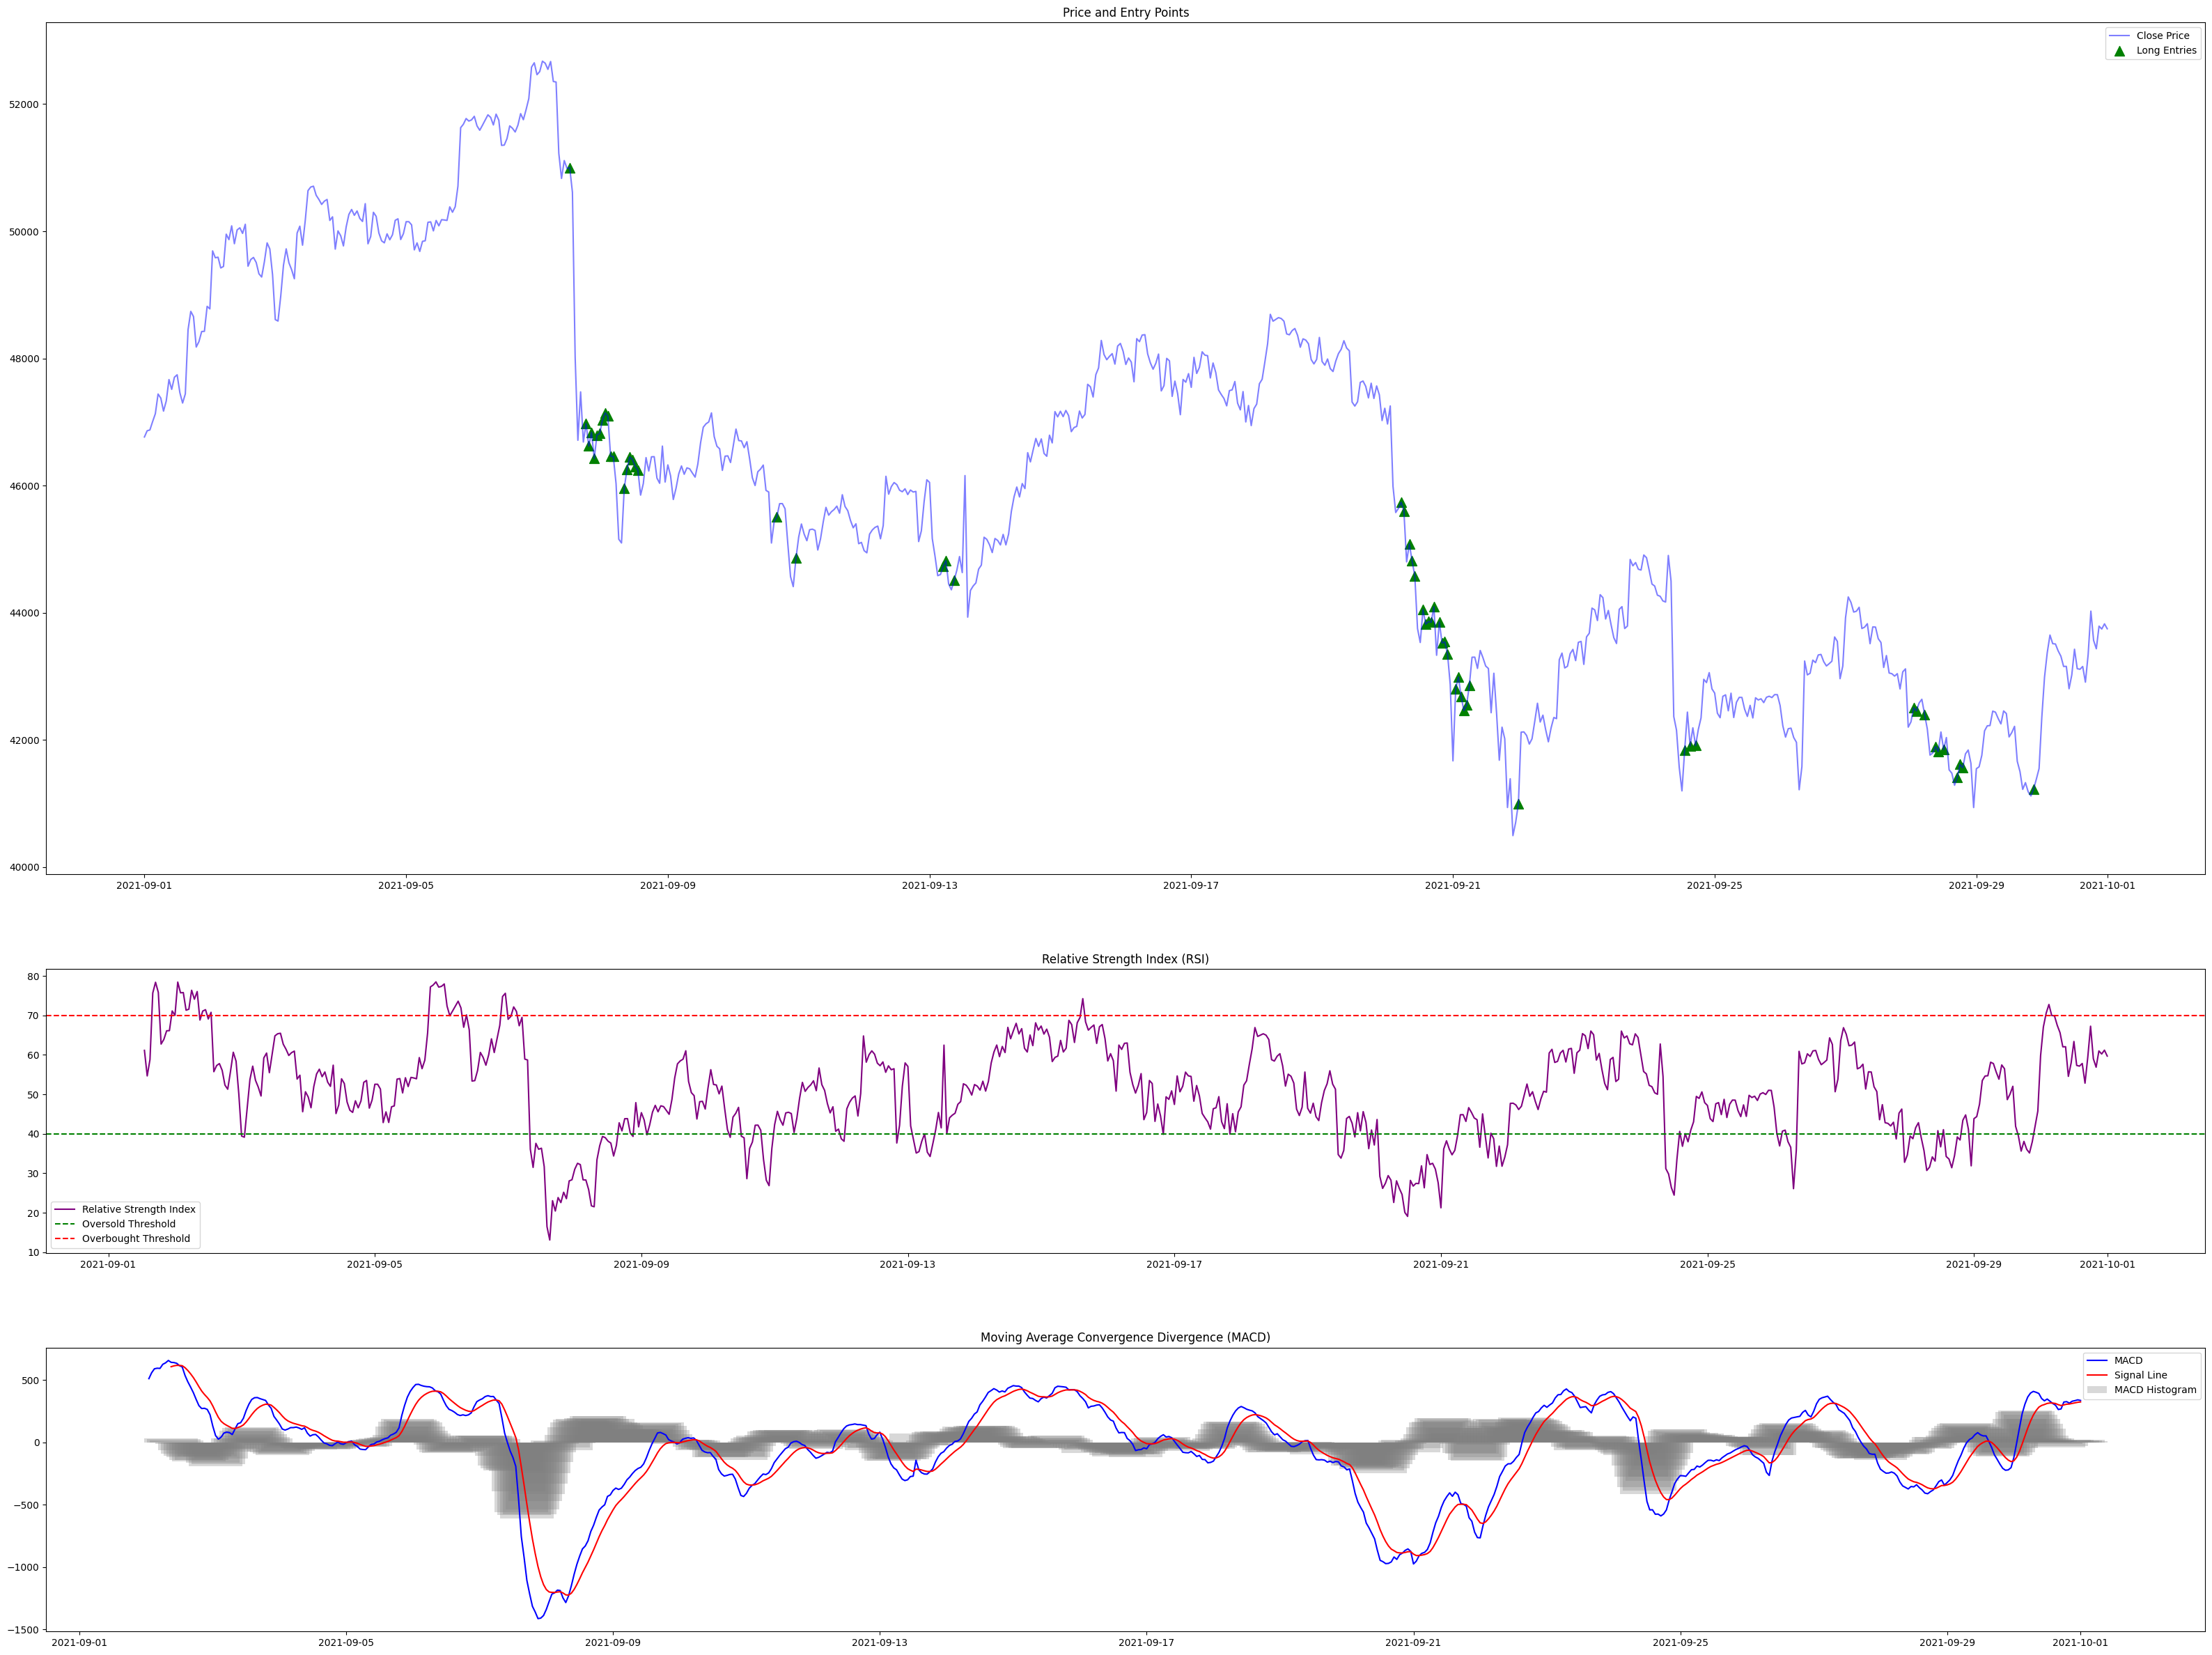

In [19]:
rsi_upper_threshold = 70
rsi_lower_threshold = 40

data['rsi'] = ta.momentum.rsi(data['close'], window=14)
data['rsi_buy'] = data['rsi'] < rsi_lower_threshold
data['rsi_sell'] = data['rsi'] > rsi_upper_threshold

data['macd'] = ta.trend.macd(data['close'], window_fast=12, window_slow=26)
data['macdsignal'] = ta.trend.macd_signal(data['close'], window_fast=12, window_slow=26, window_sign=9)
data['macdhist'] = ta.trend.macd_diff(data['close'], window_fast=12, window_slow=26, window_sign=9)
data['macdhist_last'] = data['macdhist'].shift(1)
data['macd_buy'] = data['macdhist'] > data['macdhist_last']  
data['macd_sell'] = data['macdhist'] < data['macdhist_last']

# Define entry points based on RSI and MACD
data['long_entry'] = (data['rsi_buy']) & (data['macd_buy'])
data['short_entry'] = (data['rsi_sell']) & (data['macd_sell'])

# Plotting the price, RSI, and MACD for visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(40, 30), gridspec_kw={'height_ratios': [3, 1, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
#ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price and Entry Points')
ax1.legend()

# Plot RSI
ax2.plot(data['rsi'], label='Relative Strength Index', color='purple')
ax2.axhline(rsi_lower_threshold, color='green', linestyle='--', label='Oversold Threshold')
ax2.axhline(rsi_upper_threshold, color='red', linestyle='--', label='Overbought Threshold')
ax2.set_title('Relative Strength Index (RSI)')
ax2.legend()

# Plot MACD
ax3.plot(data['macd'], label='MACD', color='blue')
ax3.plot(data['macdsignal'], label='Signal Line', color='red')
ax3.bar(data.index, data['macdhist'], label='MACD Histogram', color='grey', alpha=0.3)
ax3.set_title('Moving Average Convergence Divergence (MACD)')
ax3.legend()

plt.show()


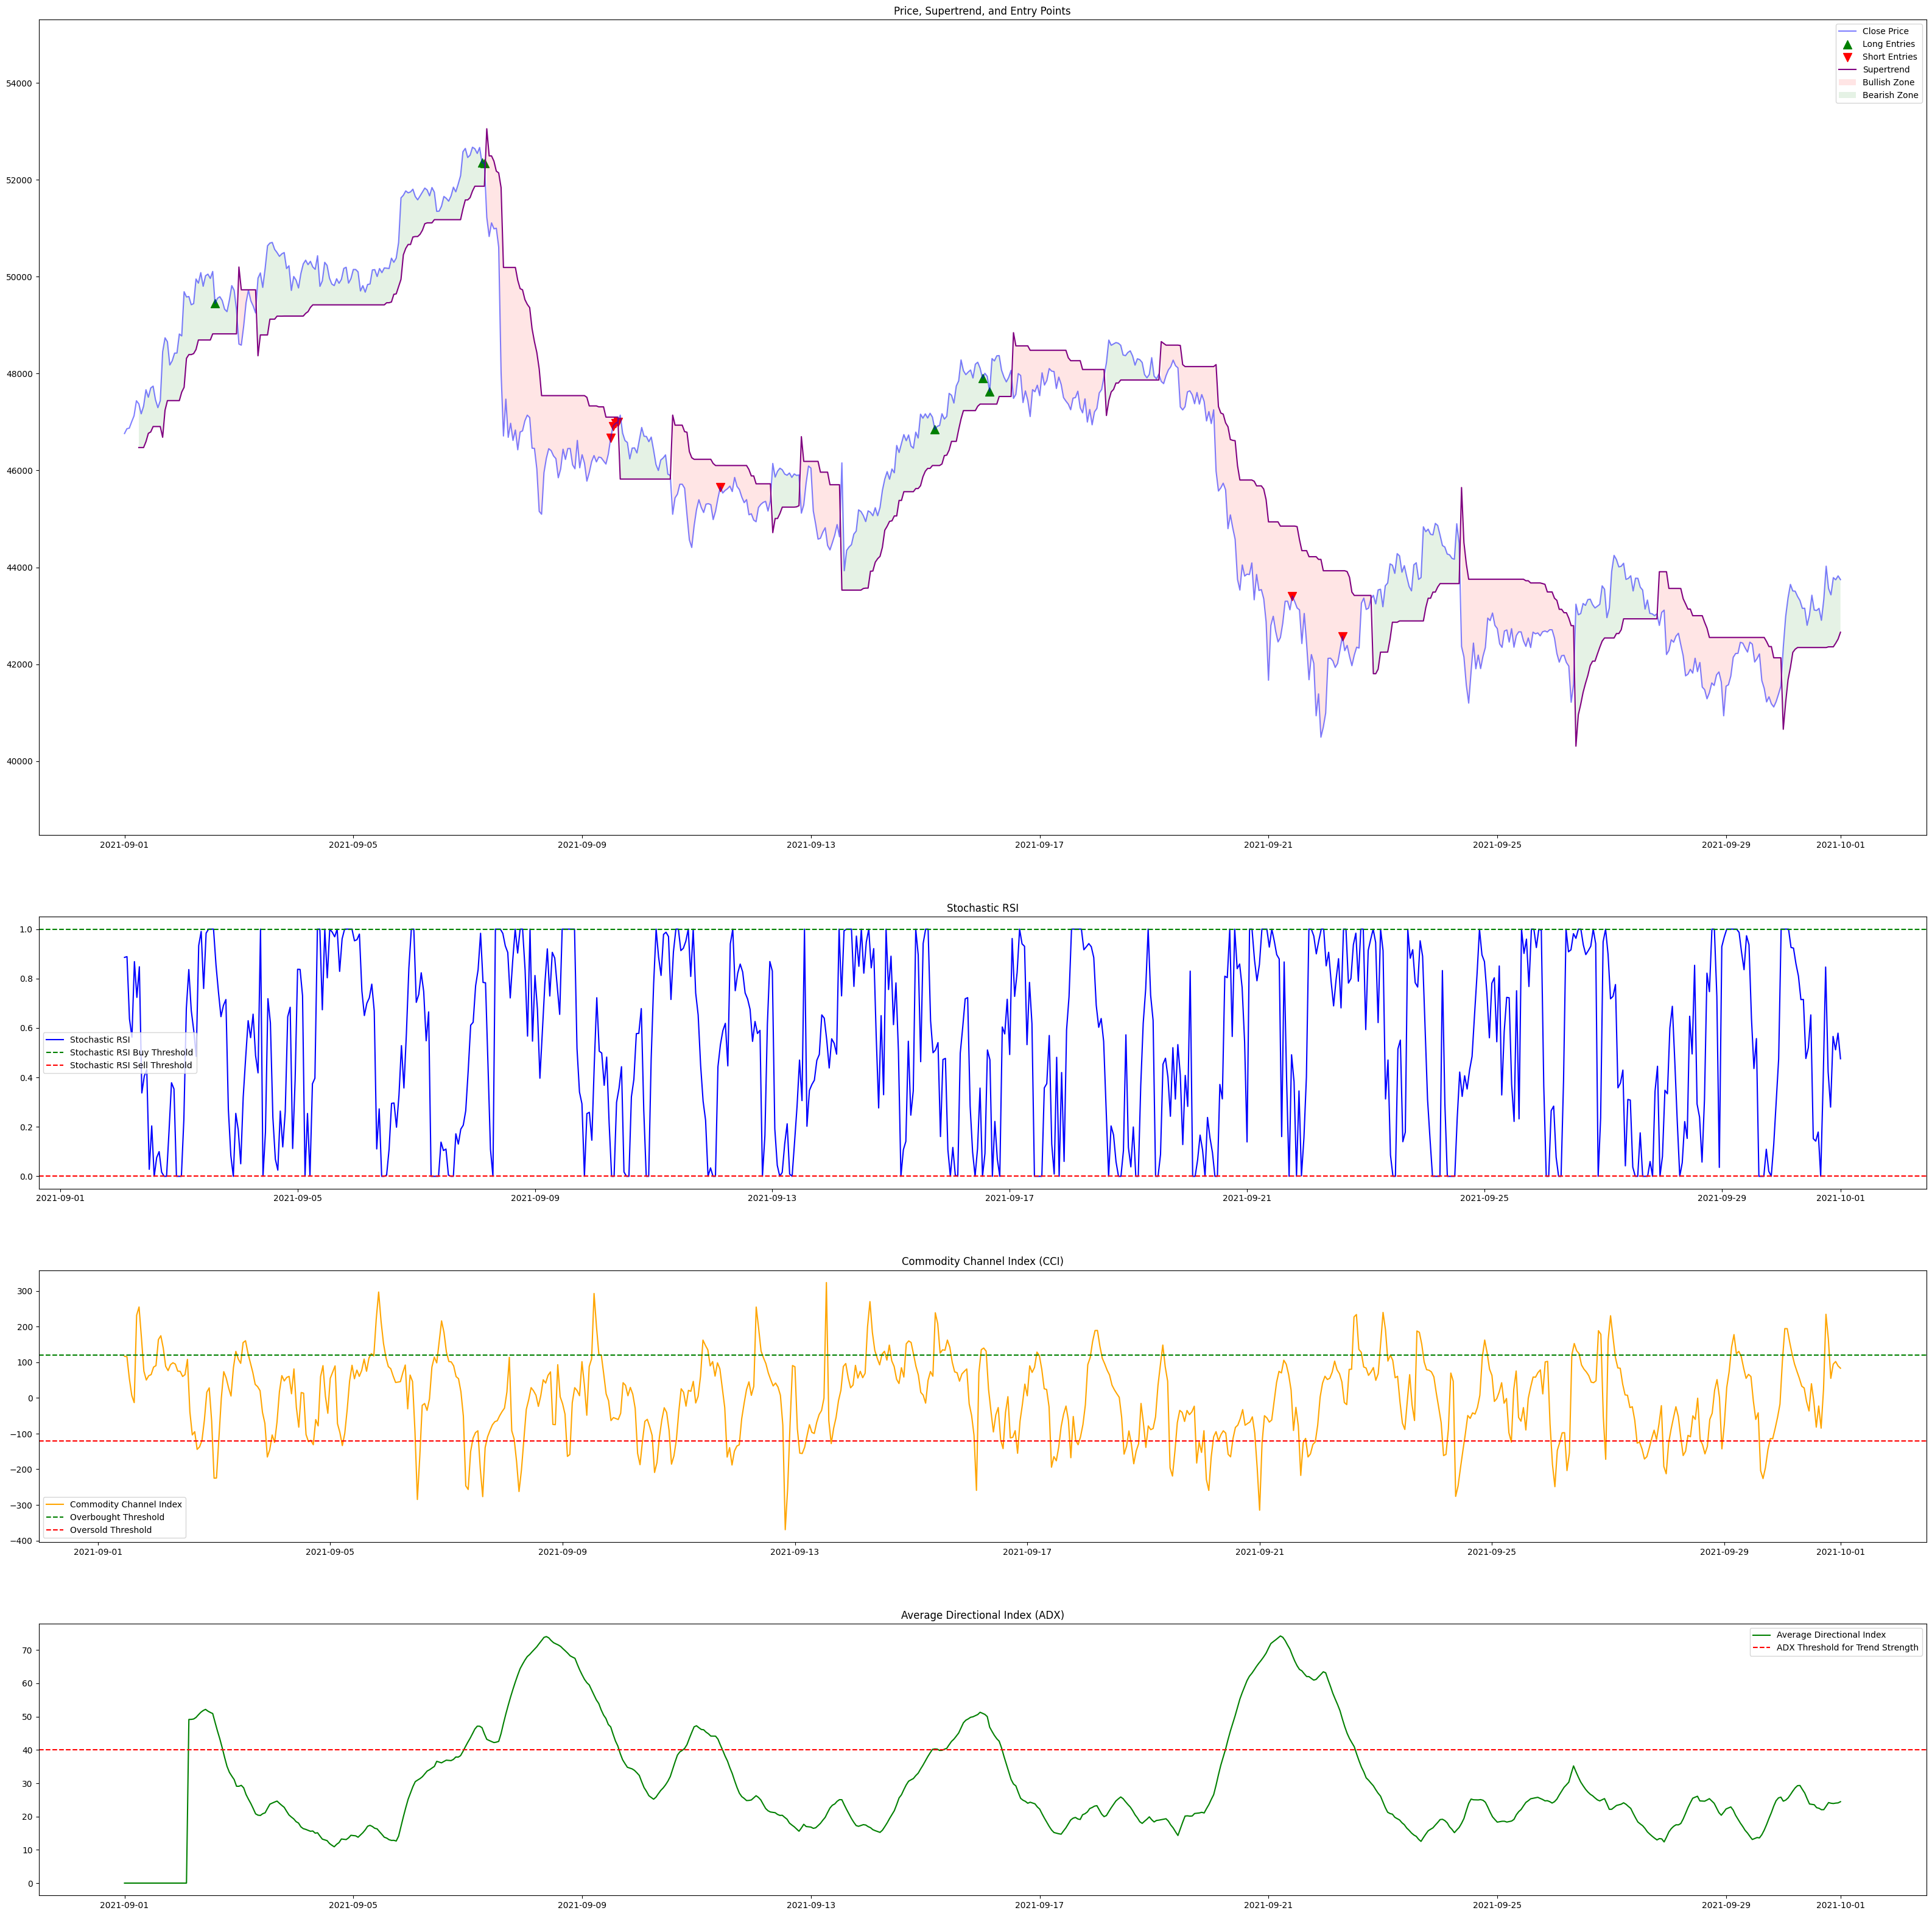

In [20]:
import pandas_ta as pta

# Calculate the Supertrend indicator
supertrend = pta.supertrend(data['high'], data['low'], data['close'], length=6, multiplier=3.0)
data['supertrend'] = supertrend['SUPERT_6_3.0']

# Calculate the Stochastic RSI
data['stoch_rsi'] = ta.momentum.stochrsi(data['close'])

# Calculate the Commodity Channel Index (CCI)
data['cci'] = ta.trend.cci(data['high'], data['low'], data['close'], window=12)

# Calculate ADX
data['adx'] = ta.trend.adx(data['high'], data['low'], data['close'], window=14)

cci_oversold_threshold = -120
cci_overbought_threshold = 120

# Define Stochastic RSI buy and sell thresholds
stoch_rsi_oversold_threshold = .999999
stoch_rsi_overbought_threshold = 0.000001

adx_threshold = 40

# Generate buy and sell signals based on Stochastic RSI, Supertrend, and ADX but filter by Supertrend
data['supertrend_uptrend_approx'] = data['close'] - data['supertrend'] > 0
data['supertrend_downtrend_approx'] = data['supertrend'] - data['close'] > 0

data['long_entry'] = ((data['stoch_rsi'] < stoch_rsi_oversold_threshold) | (data['cci'] < cci_oversold_threshold)) & (data['supertrend_uptrend_approx']) & (data['adx'] > adx_threshold) & ((data['cci'] < 100)) & (data['stoch_rsi'] < stoch_rsi_overbought_threshold)
data['short_entry'] = ((data['stoch_rsi'] > stoch_rsi_overbought_threshold) | (data['cci'] > cci_overbought_threshold)) & (data['supertrend_downtrend_approx']) & (data['adx'] > adx_threshold) & ((data['cci'] > 100)) & (data['stoch_rsi'] > stoch_rsi_oversold_threshold)

# Plotting the price, Supertrend, Stochastic RSI, CCI, and ADX for visualization
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(40, 40), gridspec_kw={'height_ratios': [3, 1, 1, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.plot(data['supertrend'], label='Supertrend', color='purple')
ax1.fill_between(data.index, data['supertrend'], data['close'], where=data['supertrend_downtrend_approx'], facecolor='red', alpha=0.1, label='Bullish Zone')
ax1.fill_between(data.index, data['supertrend'], data['close'], where=data['supertrend_uptrend_approx'], facecolor='green', alpha=0.1, label='Bearish Zone')
ax1.set_title('Price, Supertrend, and Entry Points')
ax1.legend()
ax1.set_ylim(bottom=data['close'].min() * .95, top=data['close'].max() * 1.05)

# Plot Stochastic RSI
ax2.plot(data['stoch_rsi'], label='Stochastic RSI', color='blue')
ax2.axhline(y=stoch_rsi_oversold_threshold, color='green', linestyle='--', label='Stochastic RSI Buy Threshold')
ax2.axhline(y=stoch_rsi_overbought_threshold, color='red', linestyle='--', label='Stochastic RSI Sell Threshold')
ax2.set_title('Stochastic RSI')
ax2.legend()

# Plot CCI
ax3.plot(data['cci'], label='Commodity Channel Index', color='orange')
ax3.axhline(y=cci_overbought_threshold, color='green', linestyle='--', label='Overbought Threshold')
ax3.axhline(y=cci_oversold_threshold, color='red', linestyle='--', label='Oversold Threshold')
ax3.set_title('Commodity Channel Index (CCI)')
ax3.legend()

# Plot ADX
ax4.plot(data['adx'], label='Average Directional Index', color='green')
ax4.axhline(y=adx_threshold, color='red', linestyle='--', label='ADX Threshold for Trend Strength')
ax4.set_title('Average Directional Index (ADX)')
ax4.legend()

plt.show()


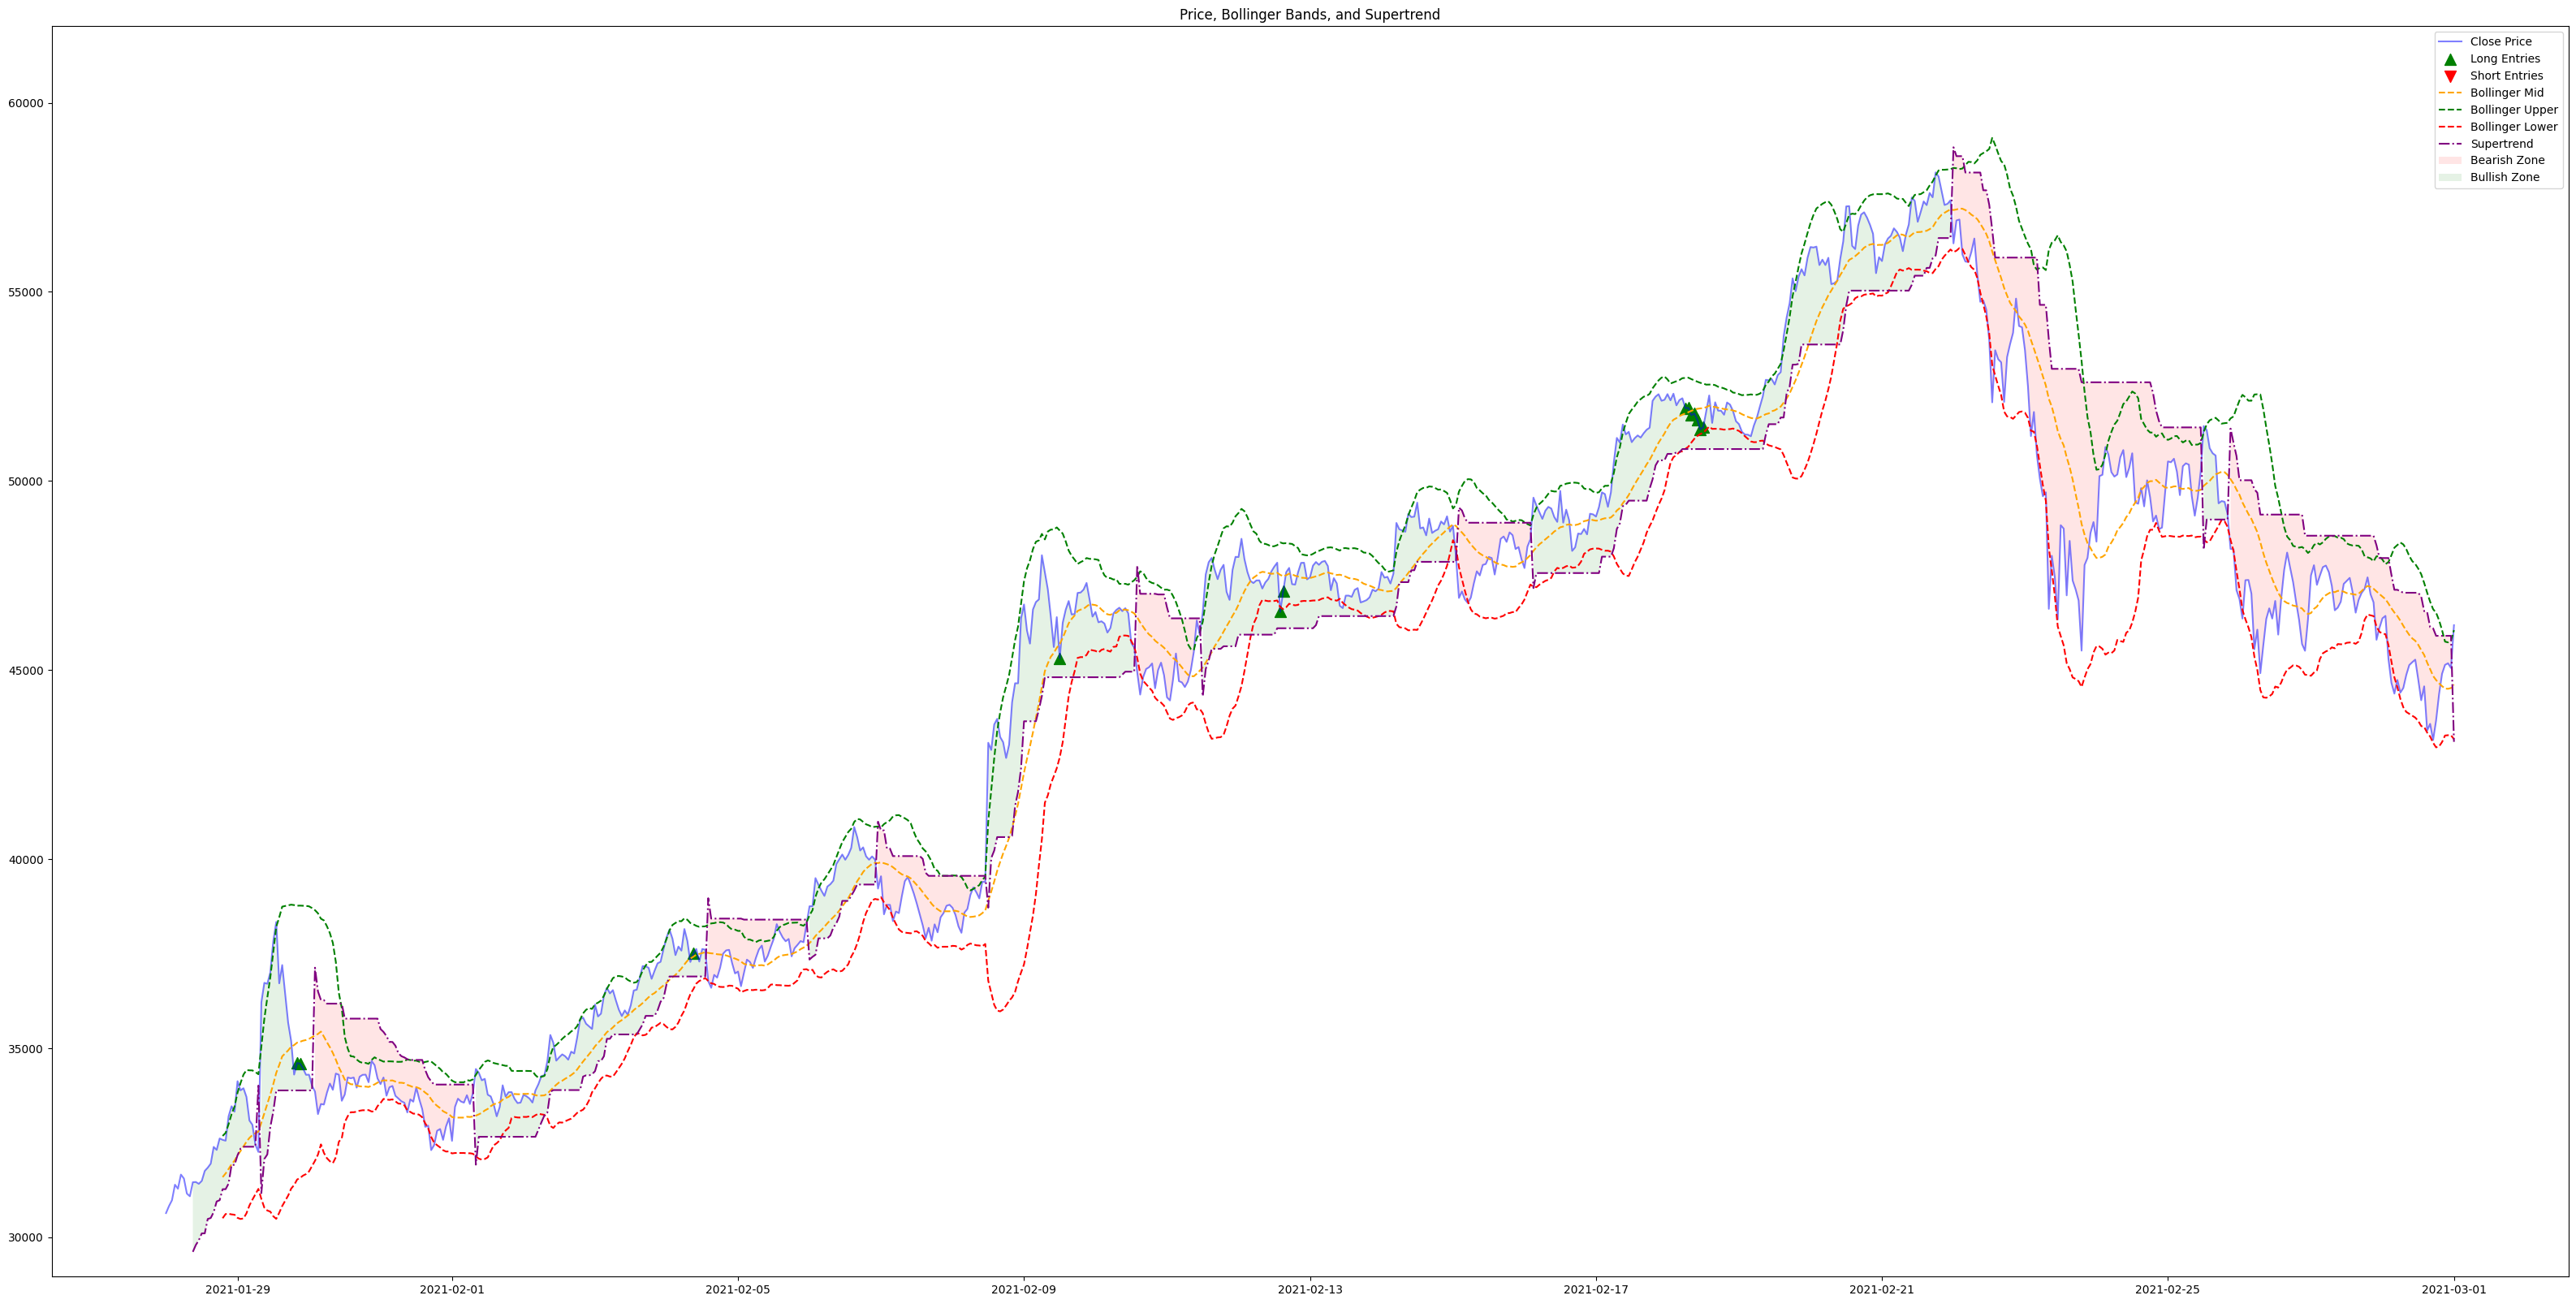

In [21]:
data = get_data_from_kraken_csv('XBTUSDT', '60', start_date=pd.Timestamp('2021-01-28'), end_date=pd.Timestamp('2021-03-01'))

data['close_last'] = data['close'].shift(1)

data['wavetrend'] = calculate_wavetrend(data)
wavetrend_overbought_threshold = 60
wavetrend_oversold_threshold = -60
data['wavetrend_overbought'] = data['wavetrend'] > wavetrend_overbought_threshold
data['wavetrend_oversold'] = data['wavetrend'] < wavetrend_oversold_threshold

supertrend = pta.supertrend(data['high'], data['low'], data['close'], length=9, multiplier=3.0)
data['supertrend'] = supertrend['SUPERT_9_3.0']
data['supertrend_last'] = data['supertrend'].shift(1)

# Define Bollinger Bands trend direction with a minimum margin for the cross-over
data['supertrend_uptrend_approx'] = data['close'] - data['supertrend'] > 0
data['supertrend_downtrend_approx'] = data['supertrend'] - data['close'] > 0

# Calculate the Commodity Channel Index (CCI)
data['cci'] = ta.trend.cci(data['high'], data['low'], data['close'], window=12)
cci_overbought_threshold = 100
cci_oversold_threshold = -100

# Calculate ADX
data['adx'] = ta.trend.adx(data['high'], data['low'], data['close'], window=12)
adx_threshold = 25

data['long_entry'] = ((data['wavetrend_oversold']) | (data['cci'] < cci_oversold_threshold)) & (data['supertrend_uptrend_approx']) & (data['adx'] > adx_threshold)
data['short_entry'] = (data['close'] != data['close'])

# Plotting the price, Bollinger Bands, and Supertrend for visualization with adjusted y scale
fig, (ax1) = plt.subplots(1, 1, figsize=(40, 20))

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.plot(data['bollinger_mid'], label='Bollinger Mid', color='orange', linestyle='--')
ax1.plot(data['bollinger_upper'], label='Bollinger Upper', color='green', linestyle='--')
ax1.plot(data['bollinger_lower'], label='Bollinger Lower', color='red', linestyle='--')
ax1.plot(data['supertrend'], label='Supertrend', color='purple', linestyle='-.')
ax1.fill_between(data.index, data['supertrend'], data['close'], where=data['supertrend_downtrend_approx'], facecolor='red', alpha=0.1, label='Bearish Zone')
ax1.fill_between(data.index, data['supertrend'], data['close'], where=data['supertrend_uptrend_approx'], facecolor='green', alpha=0.1, label='Bullish Zone')
ax1.set_title('Price, Bollinger Bands, and Supertrend')
ax1.legend()
ax1.set_ylim(bottom=min(data['bollinger_lower'].min(), data['close'].min()) * 0.95, top=max(data['bollinger_upper'].max(), data['close'].max()) * 1.05)

plt.show()